In [1]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm

## Specify HDDM Model

In [3]:
# Load one of the datasets shipping with HDDM
cav_data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')

In [4]:
cav_data

subj_idx stim     rt  response     theta  dbs conf
0            0   LL  1.210       1.0  0.656275    1   HC
1            0   WL  1.630       1.0 -0.327889    1   LC
2            0   WW  1.030       1.0 -0.480285    1   HC
3            0   WL  2.770       1.0  1.927427    1   LC
4            0   WW  1.140       0.0 -0.213236    1   HC
...        ...  ...    ...       ...       ...  ...  ...
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

[3988 rows x 7 columns]

In [6]:
basic_hddm_model = hddm.HDDM(cav_data,
                             informative = False,
                             include = ['v', 'a', 't', 'z'], 
                             is_group_model = True,
                             depends_on = {'v': ['stim']})

No model attribute --> setting up standard HDDM
Includes supplied:  ['v', 'a', 't', 'z']
Set model to ddm


In [7]:
basic_hddm_model.sample(1000, burn = 500)

 [-----------------100%-----------------] 1000 of 1000 complete in 332.9 sec

#### A Central Database for Models: `hddm.model_config`

In [3]:
hddm.model_config.model_config.keys()

dict_keys(['ddm_vanilla', 'full_ddm_vanilla', 'ddm', 'angle', 'weibull', 'levy', 'full_ddm', 'ornstein', 'ddm_sdv', 'ddm_par2', 'ddm_par2_no_bias', 'ddm_par2_angle_no_bias', 'ddm_par2_weibull_no_bias', 'ddm_seq2', 'ddm_seq2_no_bias', 'ddm_seq2_angle_no_bias', 'ddm_seq2_weibull_no_bias', 'ddm_mic2_adj', 'ddm_mic2_adj_no_bias', 'ddm_mic2_adj_angle_no_bias', 'ddm_mic2_adj_weibull_no_bias', 'race_no_bias_3', 'race_no_bias_angle_3', 'race_no_bias_4', 'race_no_bias_angle_4', 'lca_no_bias_3', 'lca_no_bias_angle_3', 'lca_no_bias_4', 'lca_no_bias_angle_4', 'weibull_cdf', 'full_ddm2'])

In [6]:
hddm.model_config.model_config["ddm"] =  {
    "params": ["v", "a", "z", "t"], 
    "params_trans": [0, 0, 1, 0],  
    "param_bounds": [[-3.0, 0.3, 0.1, 1e-3], [3.0, 2.5, 0.9, 2.0]], 
    "boundary": hddm.simulators.bf.constant,
    "hddm_include": ["z"],
    "choices": [-1, 1],
    "params_default": [0.0, 1.0, 0.5, 1e-3],
    "params_std_upper": [1.5, 1.0, None, 1.0],
    }

#### Batteries Included: `hddm.simulators` , `hddm.network_inspectors`

In [2]:
print(hddm.model_config.model_config['angle']['doc'])

Model formulation is described in the documentation under LAN Extension.
Meant for use with the extension.


In [11]:
from hddm.simulators import simulator
theta_tmp = hddm.model_config.model_config['angle']['params_default']
model = 'angle'
out = simulator(model = 'angle',
                theta = theta_tmp,
                n_samples = 100,
                delta_t = 0.001)

theta is supplied as list --> simulator assumes n_trials = 1


In [12]:
# Specify model
lan_angle = hddm.network_inspectors.get_torch_mlp(model = 'angle')

In [13]:
# Make some random parameter set
from hddm.simulators import make_parameter_vectors_nn
parameter_df = make_parameter_vectors_nn(model = model,
                        param_dict = None,
                        n_parameter_vectors = 1)

parameter_matrix = np.tile(np.squeeze(parameter_df.values), 
                           (200, 1))

# Initialize network input
network_input = np.zeros((parameter_matrix.shape[0], 
                          parameter_matrix.shape[1] + 2)) 
# Note the + 2 on the right 
# we append the parameter vectors with 
# reaction times (+1 columns) and choices (+1 columns)

# Add reaction times
network_input[:, -2] = np.linspace(0, 3, 
                                   parameter_matrix.shape[0])

# Add choices
network_input[:, -1] = np.repeat(np.random.choice([-1, 1]), 
                                 parameter_matrix.shape[0])

# Note: The networks expects float32 inputs
network_input = network_input.astype(np.float32)

# Show example output
print('Some network outputs')
print(lan_angle(network_input)[:10]) # printing the first 10 outputs
print('Shape')
print(lan_angle(network_input).shape) # original shape of output

Some network outputs
[[-6.5302606 ]
 [ 0.5264375 ]
 [ 0.410895  ]
 [-0.52280986]
 [-1.0521754 ]
 [-1.552991  ]
 [-2.0735168 ]
 [-2.6183672 ]
 [-3.2071779 ]
 [-3.878473  ]]
Shape
(200, 1)


1 of 6
2 of 6
3 of 6
4 of 6
5 of 6
6 of 6


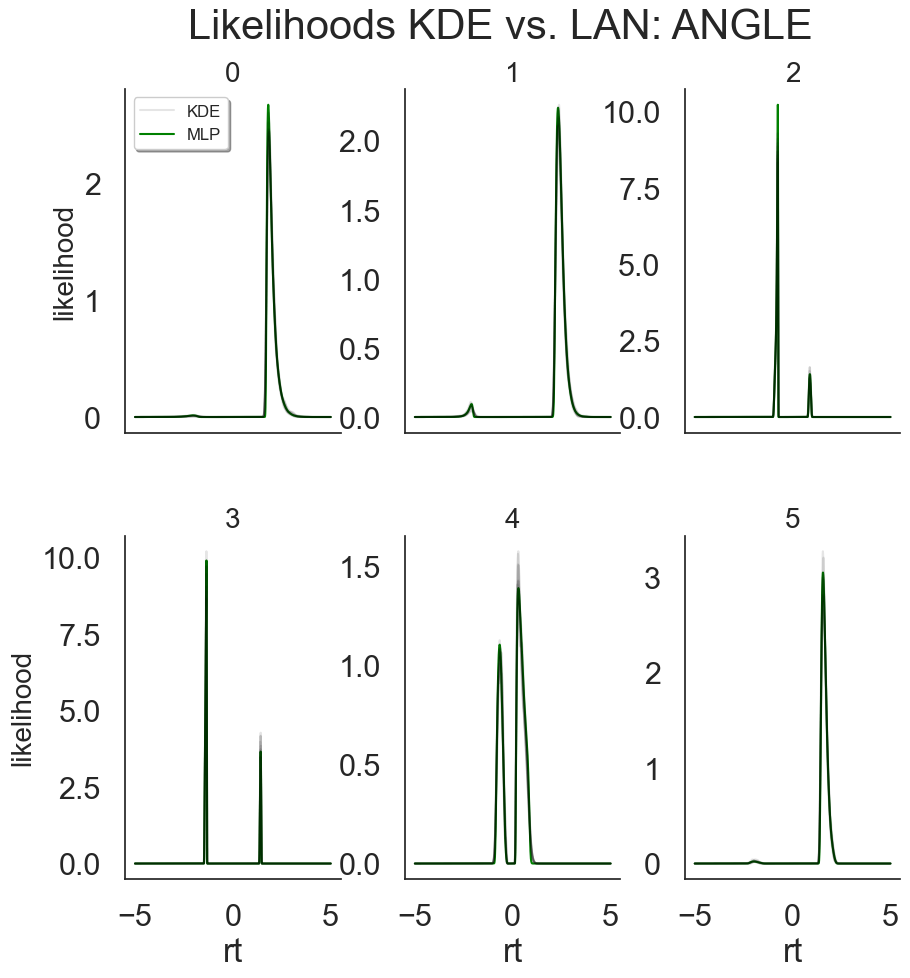

In [14]:
from hddm.network_inspectors import kde_vs_lan_likelihoods

# Make a set of parameter vectors
parameter_df = make_parameter_vectors_nn(model = model,
                        param_dict = None,
                        n_parameter_vectors = 6)

# Generate plot
kde_vs_lan_likelihoods(parameter_df = parameter_df, 
                       model = model,
                       n_samples = 1000,
                       n_reps = 10,
                       font_scale = 1.25)

#### Fitting data using `HDDMnn`, `HDDMnnRegressor`, `HDDMnnStimCoding`

In [17]:
# Load one of the datasets shipping with HDDM
cav_data = hddm.load_csv(hddm.__path__[0] + '/examples/cavanagh_theta_nn.csv')

In [18]:
cav_data

subj_idx stim     rt  response     theta  dbs conf
0            0   LL  1.210       1.0  0.656275    1   HC
1            0   WL  1.630       1.0 -0.327889    1   LC
2            0   WW  1.030       1.0 -0.480285    1   HC
3            0   WL  2.770       1.0  1.927427    1   LC
4            0   WW  1.140       0.0 -0.213236    1   HC
...        ...  ...    ...       ...       ...  ...  ...
3983        13   LL  1.450       0.0 -1.237166    0   HC
3984        13   WL  0.711       1.0 -0.377450    0   LC
3985        13   WL  0.784       1.0 -0.694194    0   LC
3986        13   LL  2.350       0.0 -0.546536    0   HC
3987        13   WW  1.250       1.0  0.752388    0   HC

[3988 rows x 7 columns]

In [19]:
hddmnn_model_cav = hddm.HDDMnn(cav_data,
            model = 'angle',
            informative = False,
            include = ['z', 'theta'], 
            is_group_model = True)

In [20]:
hddmnn_model_cav.sample(1000, burn = 500)

 [-----------------100%-----------------] 1001 of 1000 complete in 755.9 sec

#### New Visualization Plots: `hddm.plotting`

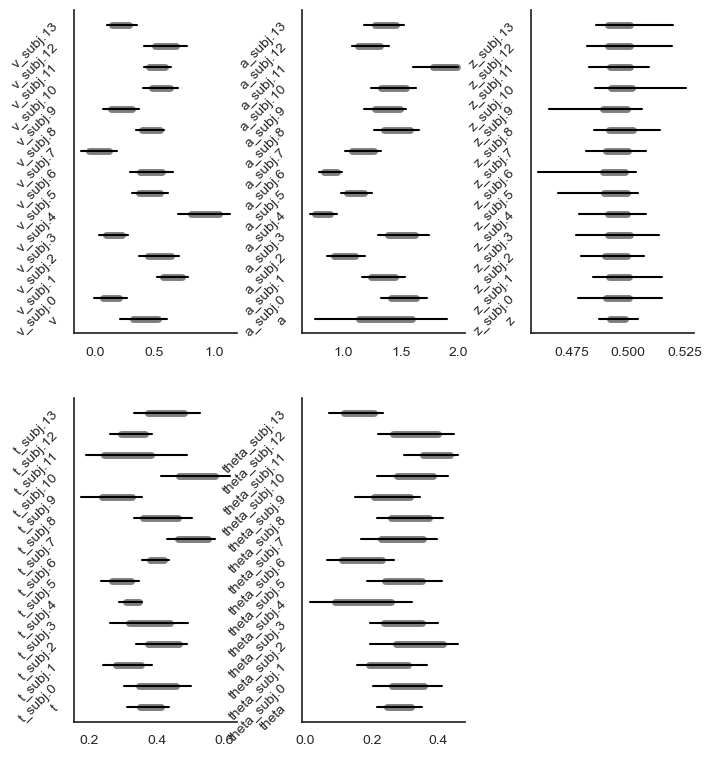

In [21]:
from hddm.plotting import plot_caterpillar

plot_caterpillar(hddm_model = hddmnn_model_cav, 
                 figsize = (8, 8),
                 columns = 3)

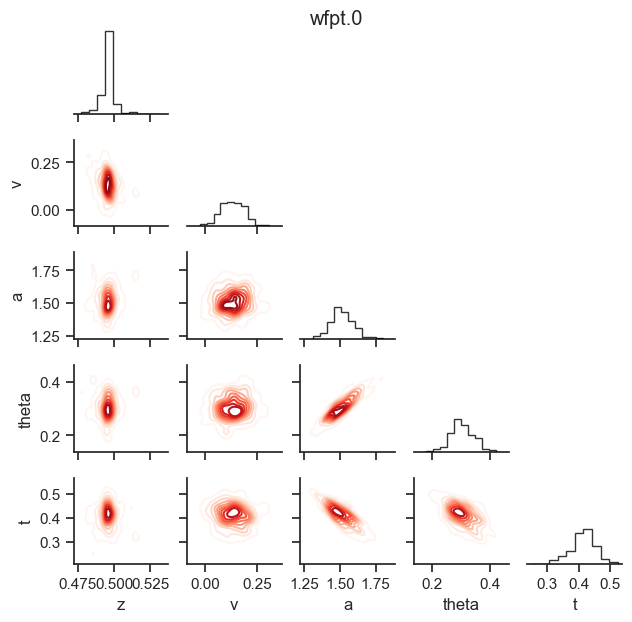

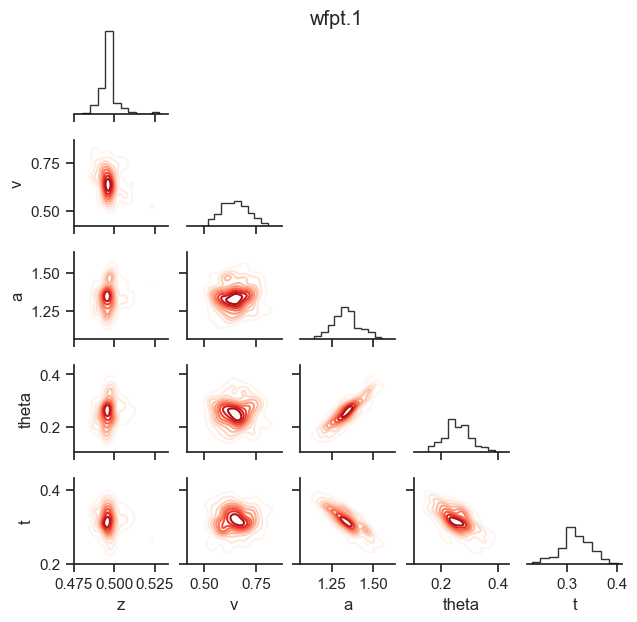

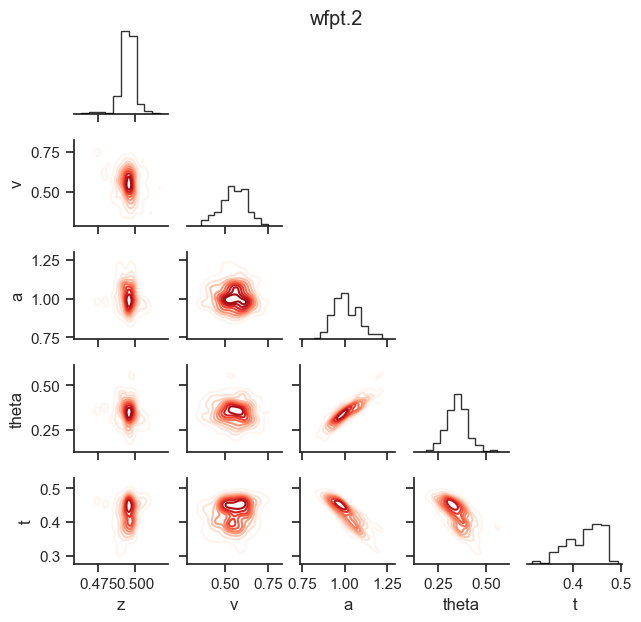

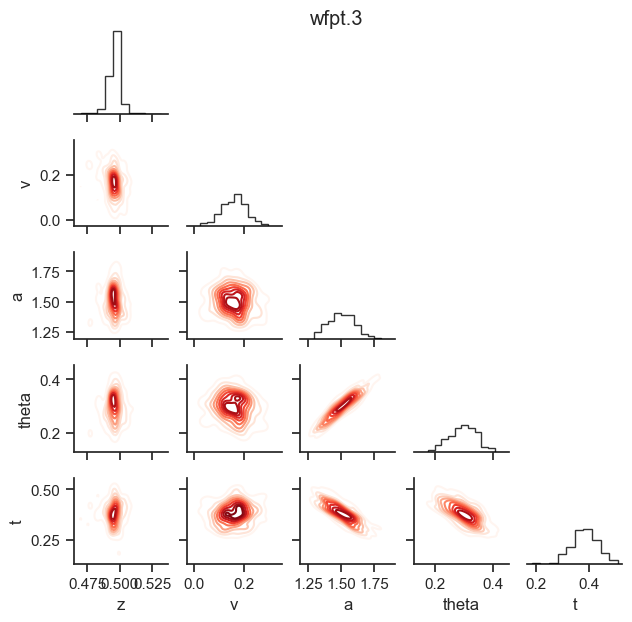

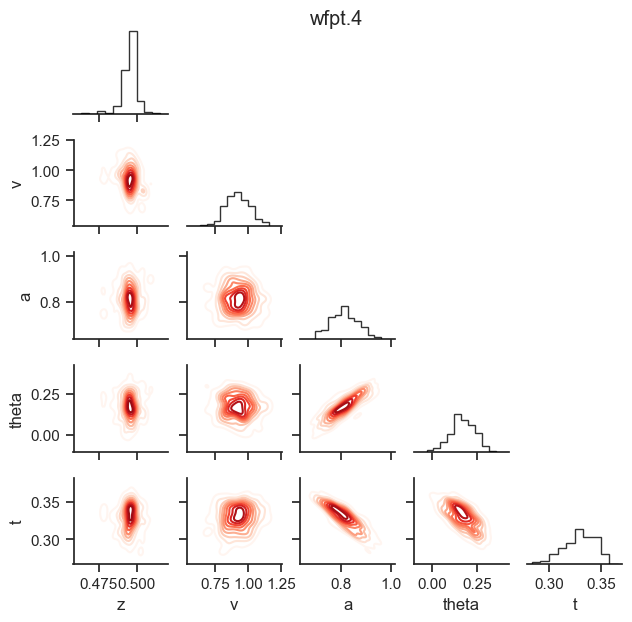

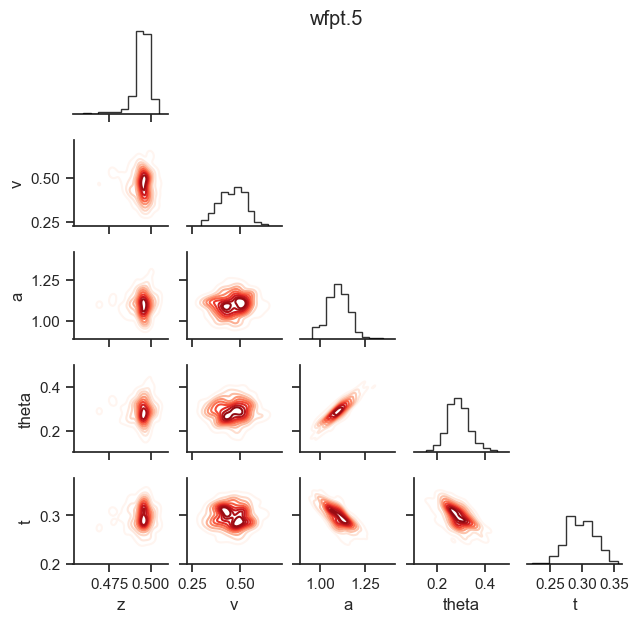

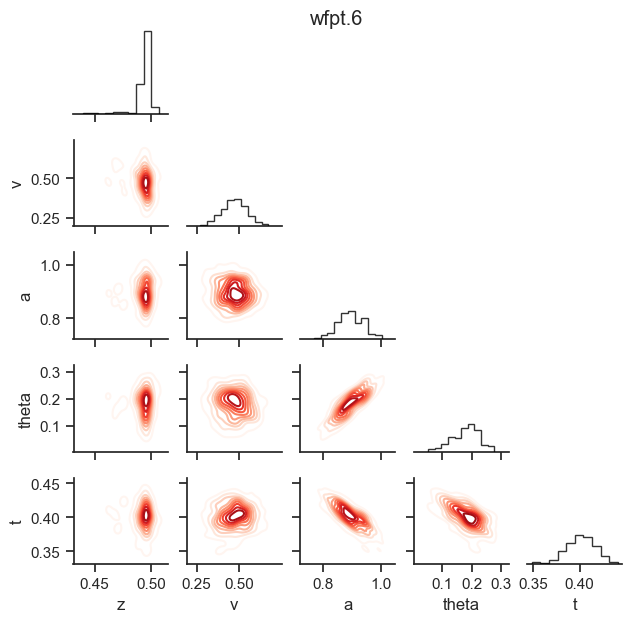

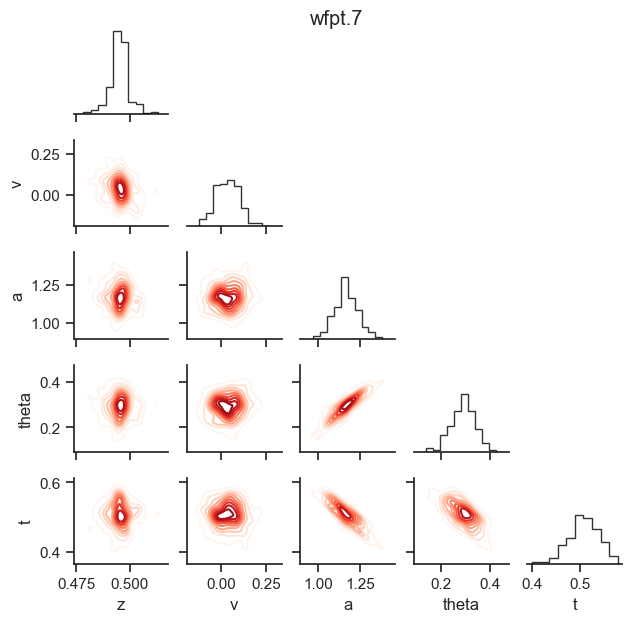

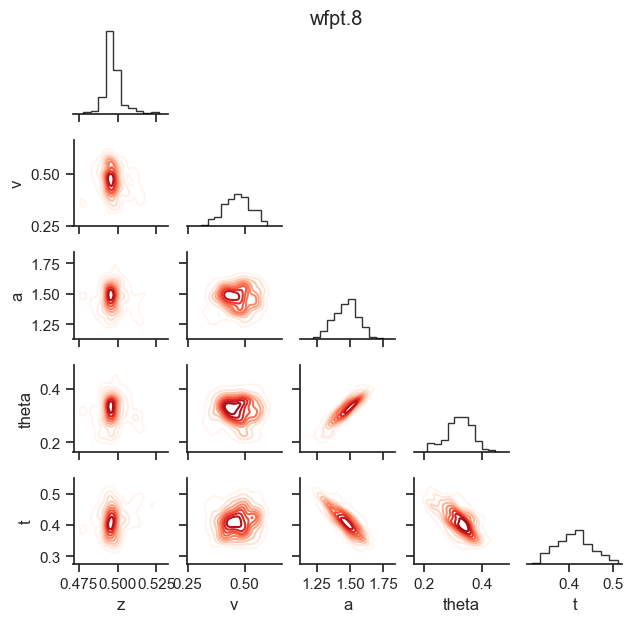

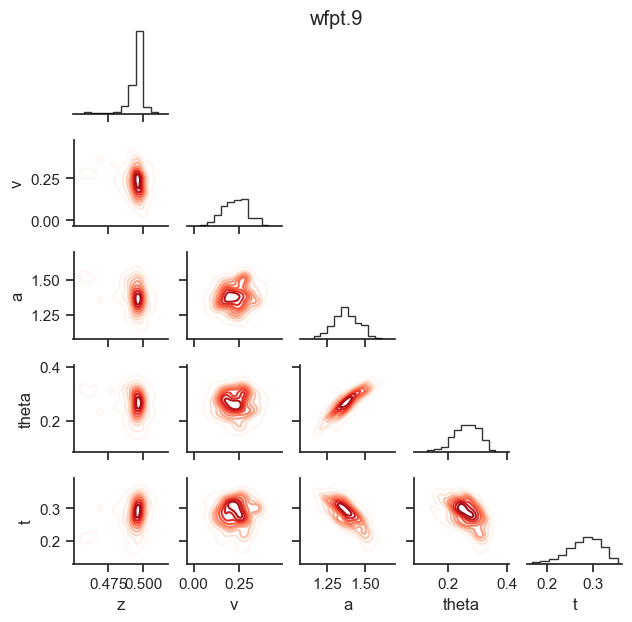

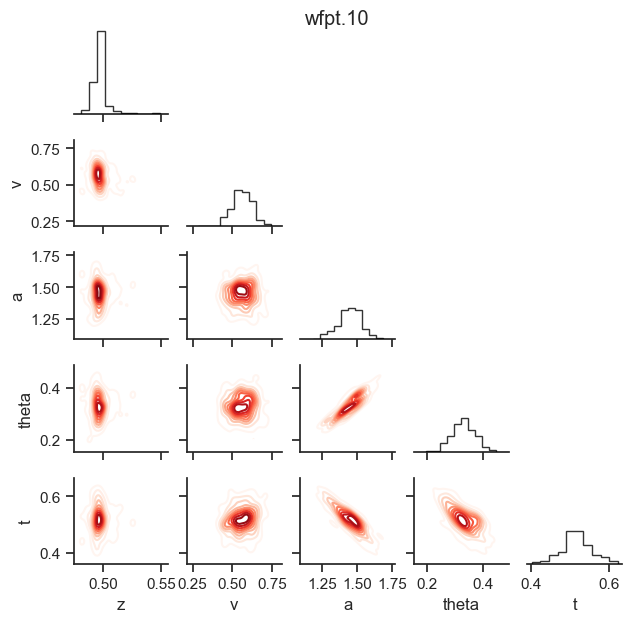

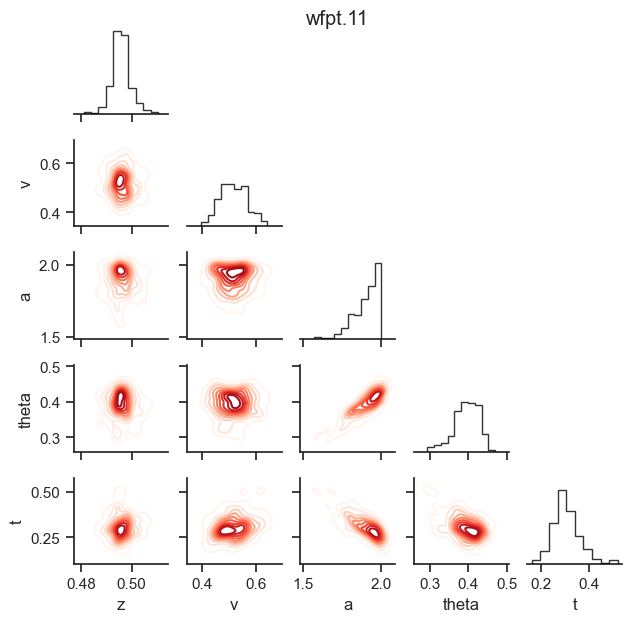

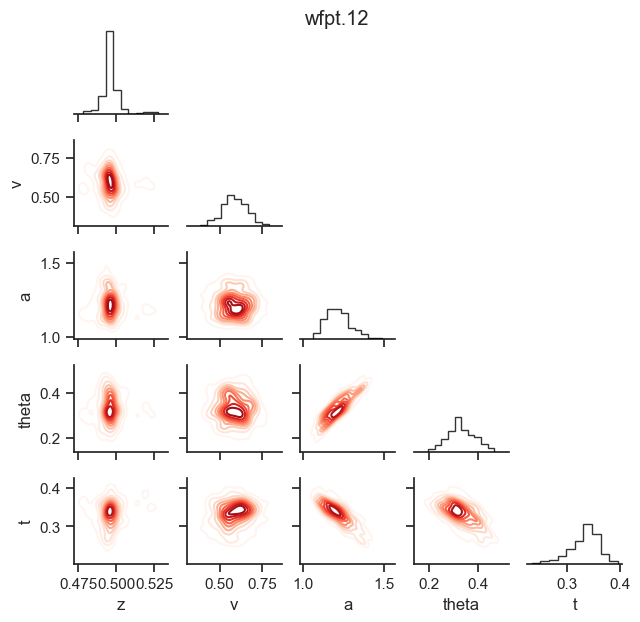

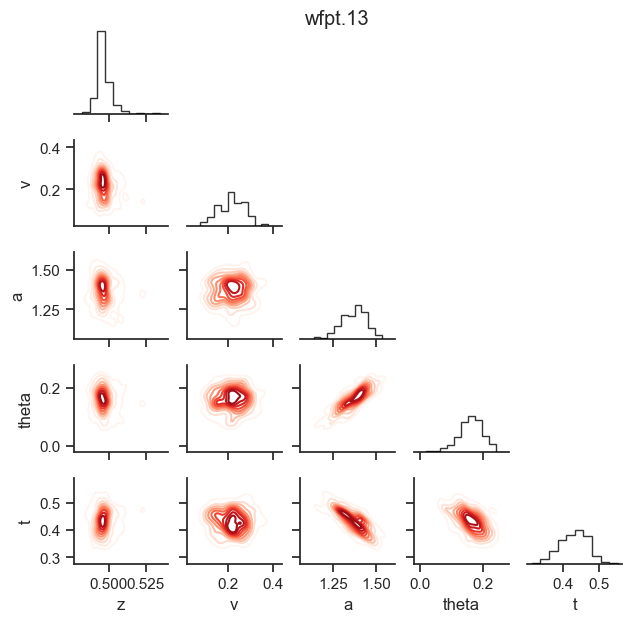

In [22]:
from hddm.plotting import plot_posterior_pair
plot_posterior_pair(hddmnn_model_cav,
                    samples = 500,
                    figsize = (6, 6))

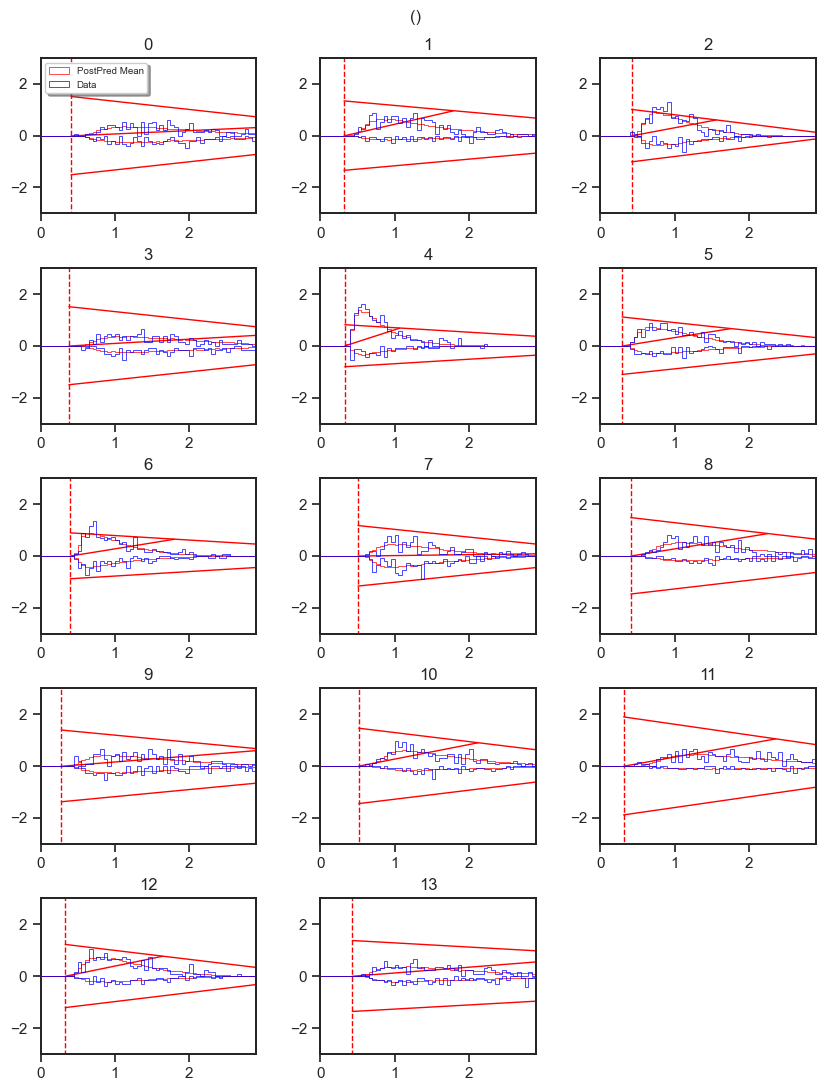

In [26]:
from hddm.plotting import plot_posterior_predictive
plot_posterior_predictive(model = hddmnn_model_cav,
                          columns = 3,
                          figsize = (10, 12),
                          groupby = ['subj_idx'],
                          value_range = np.arange(0.0, 3, 0.1),
                          plot_func = hddm.plotting._plot_func_model,
                          **{'alpha': 0.01,
                          'ylim': 3,
                          'samples': 200,
                          'legend_fontsize': 7.,
                          'legend_location': 'upper left',
                          'add_posterior_uncertainty_rts': True,
                          'add_posterior_uncertainty_rts': False,
                          'subplots_adjust': {'top': 0.94, 'hspace': 0.35, 'wspace': 0.3}
                          })
plt.show()

#### Inference Validation Tools: `simulator_h_c()`

In [27]:
# Generate some data
from hddm.simulators.hddm_dataset_generators import simulator_h_c
sim_data, parameter_dict = simulator_h_c(data = cav_data,
                                     model = 'angle',
                                     p_outlier = 0.00, 
                                     depends_on = {'v': ['stim'], 'theta': ['stim']}, 
                                     regression_models = None,
                                     regression_covariates = None,
                                     group_only_regressors = False,
                                     group_only = None,
                                     fixed_at_default = None)

depends_on is:  {'v': ['stim'], 'theta': ['stim']}
new round of data simulation because parameter bounds where violated


In [29]:
sim_data

subj_idx stim        rt  response     theta  dbs conf         v  \
0            0   LL  1.941858       1.0  0.579124    1   HC -0.210581   
1            0   WL  1.858859       0.0  0.827685    1   LC -0.137209   
2            0   WW  2.123856       0.0  0.405192    1   HC  0.588347   
3            0   WL  1.705859       1.0  0.827685    1   LC -0.137209   
4            0   WW  2.338853       1.0  0.405192    1   HC  0.588347   
...        ...  ...       ...       ...       ...  ...  ...       ...   
3983        13   LL  2.206017       1.0  0.675330    0   HC -0.210399   
3984        13   WL  2.909028       0.0  0.561203    0   LC -0.137568   
3985        13   WL  1.838021       1.0  0.561203    0   LC -0.137568   
3986        13   LL  1.982019       0.0  0.675330    0   HC -0.210399   
3987        13   WW  2.314015       0.0  0.472585    0   HC  0.575789   

             a         z         t  
0     1.098452  0.517660  1.560859  
1     1.098452  0.517660  1.560859  
2     1.098452  0.517660  1.560859  
3     1.098452  0.517660  1.560859  
4     1.098452  0.517660  1.560859  
...        ...       ...       ...  
3983  1.226248  0.504103  1.562021  
3984  1.226248  0.504103  1.562021  
3985  1.226248  0.504103  1.562021  
3986  1.226248  0.504103  1.562021  
3987  1.226248  0.504103  1.562021  

[3988 rows x 11 columns]

In [35]:
hddmnn_model_sim = hddm.HDDMnn(sim_data,
                               model = 'angle',
                               include = ['z', 'theta'], 
                               is_group_model = True,
                               depends_on = {'v': ['stim'], 
                                             'theta': ['stim']},
                               p_outlier = 0.00)

Using default priors: Uninformative


In [36]:
hddmnn_model_sim.sample(1000, burn = 500)

 [-----------------100%-----------------] 1001 of 1000 complete in 2214.5 sec

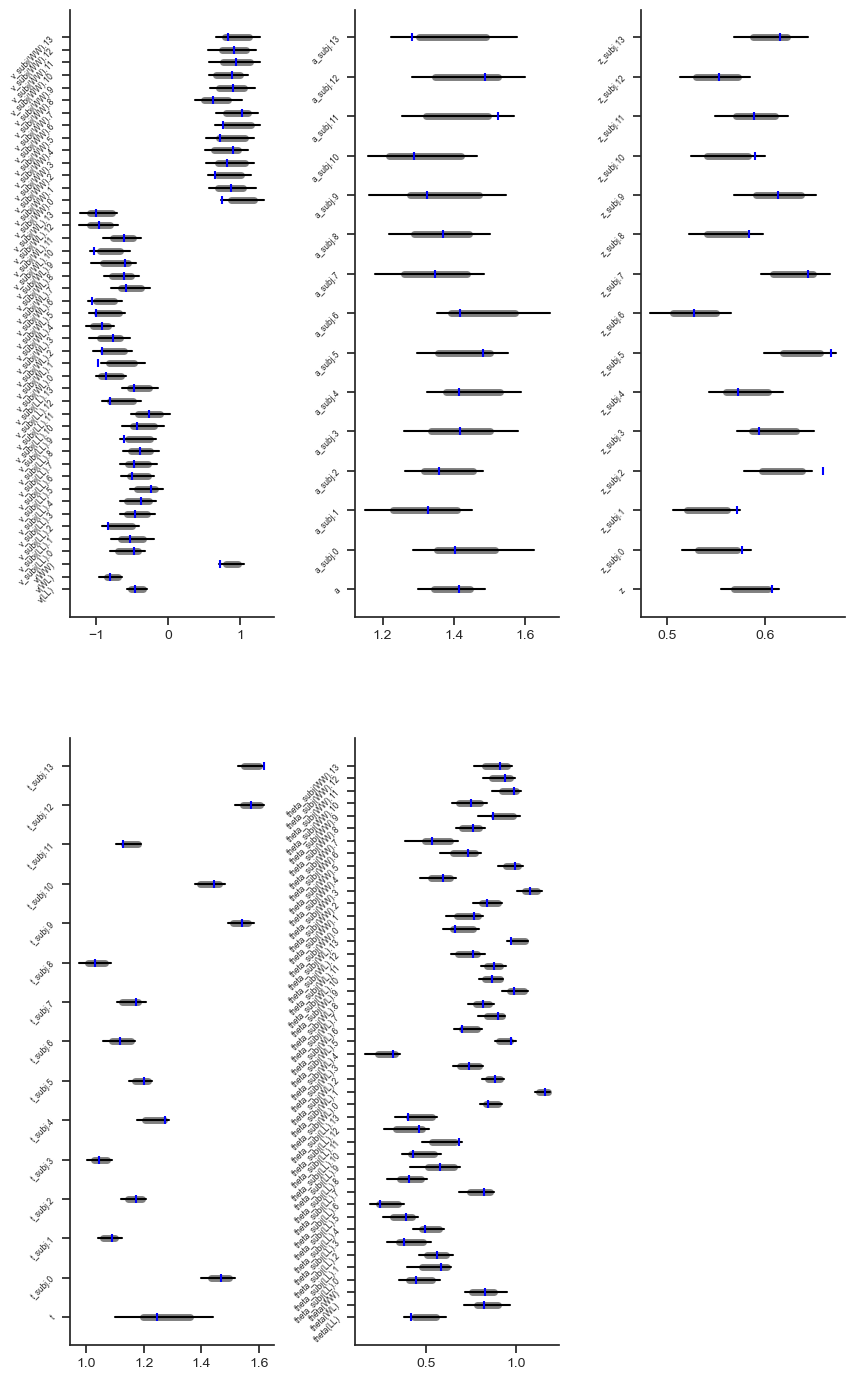

In [46]:
from hddm.plotting import plot_caterpillar
plot_caterpillar(hddm_model = hddmnn_model_sim,
                 ground_truth_parameter_dict = parameter_dict,
                 figsize = (10, 15),
                 y_tick_size = 6,
                 columns = 3)

plt.show()

In [34]:
from hddm.plotting import plot_posterior_predictive
plot_posterior_predictive(model = hddmnn_model_sim,
                          columns = 3,
                          figsize = (10, 12),
                          groupby = ['subj_idx'],
                          value_range = np.arange(0.0, 3, 0.1),
                          plot_func = hddm.plotting._plot_func_model,
                          parameter_recovery_mode = True,
                          **{'alpha': 0.01,
                          'ylim': 3,
                          'samples': 100,
                          'legend_fontsize': 7.,
                          'legend_loc': 'upper left',
                          'add_posterior_uncertainty_rts': False,
                          'add_posterior_mean_rts': True,
                          'add_posterior_mean_model': True,
                          'add_posterior_mean_rts': True,
                          'subplots_adjust': {'top': 0.94, 'hspace': 0.35, 'wspace': 0.3}
                          })

ValueError: low >= high

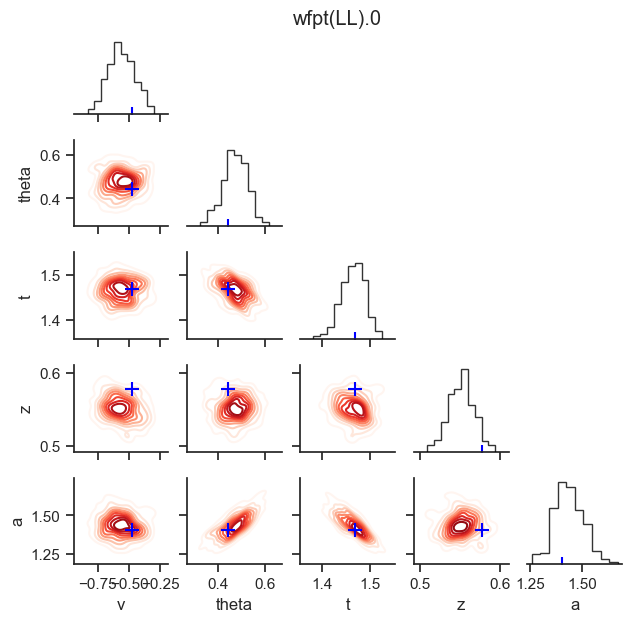

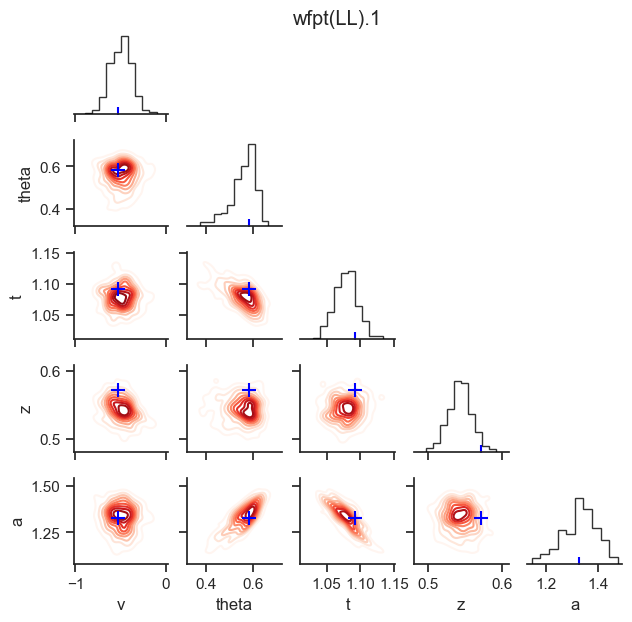

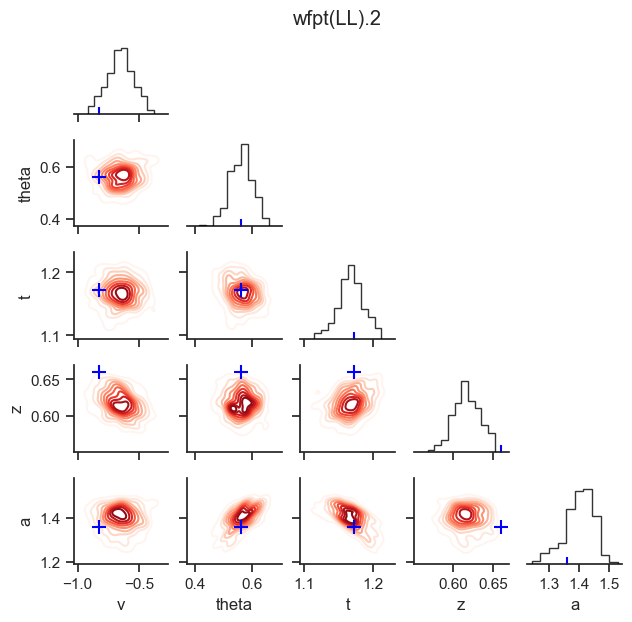

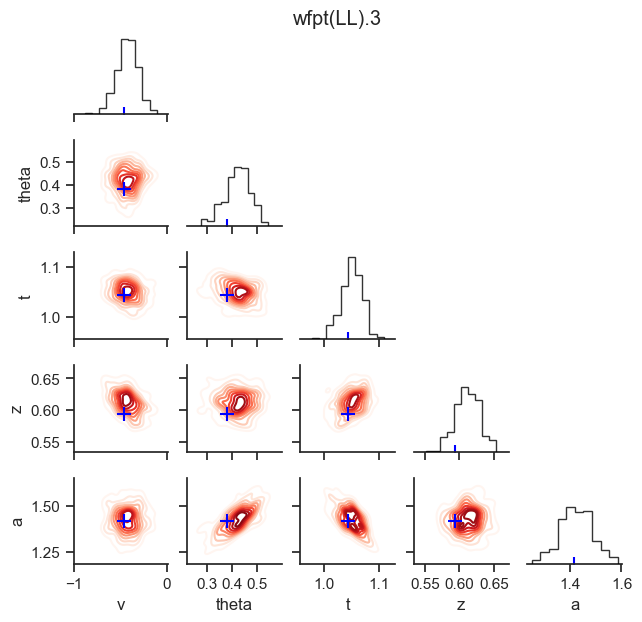

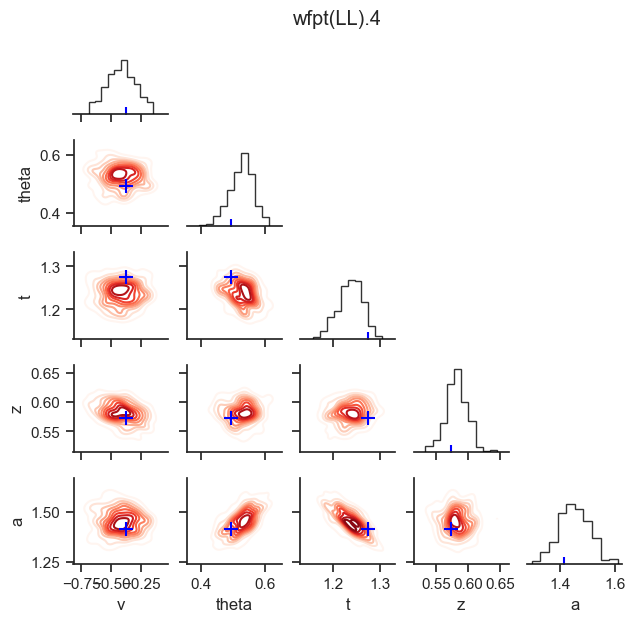

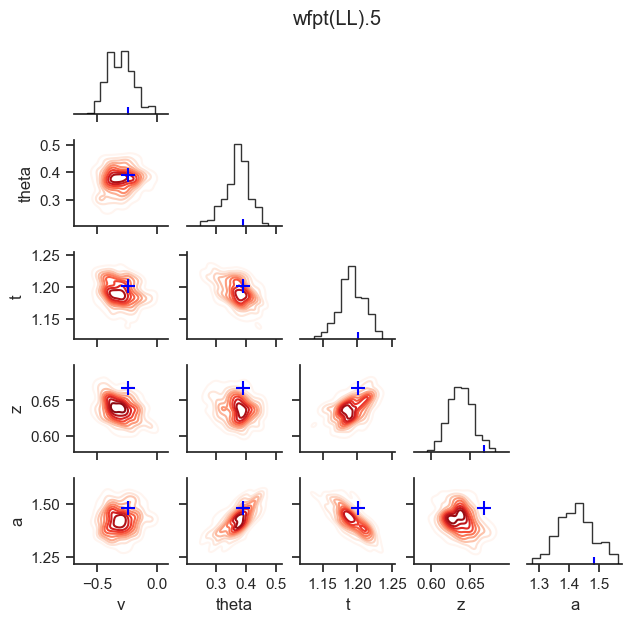

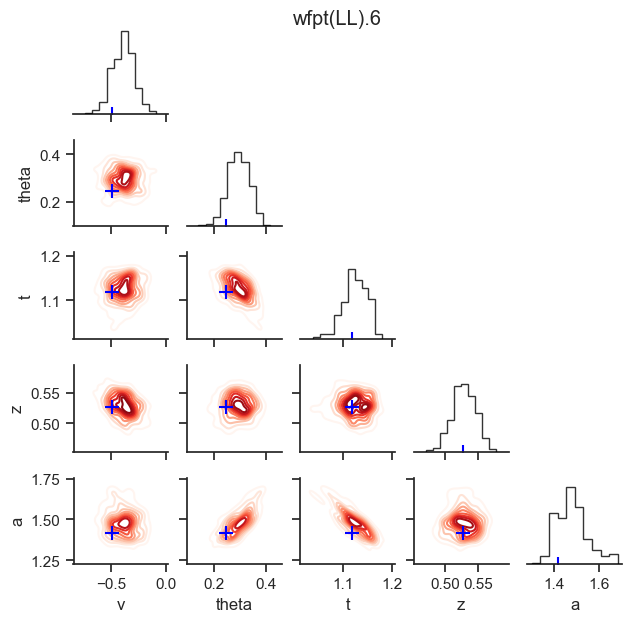

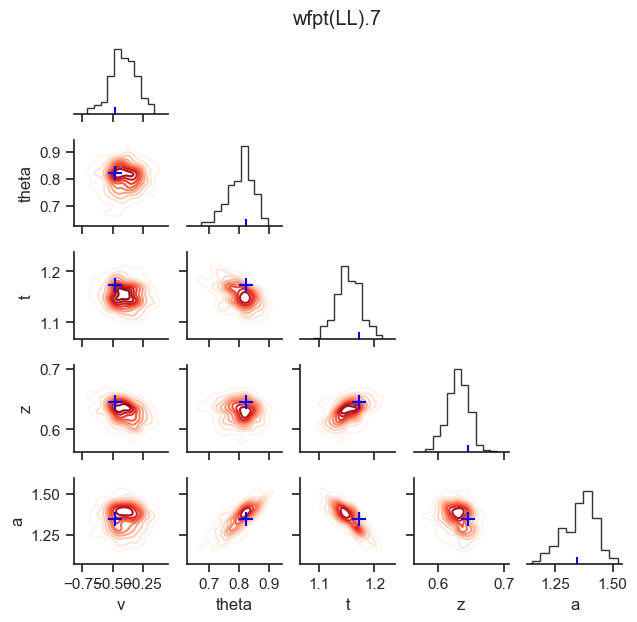

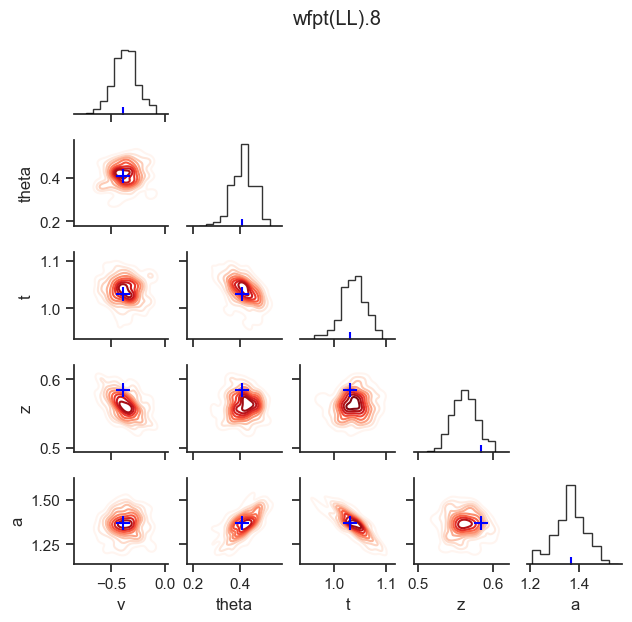

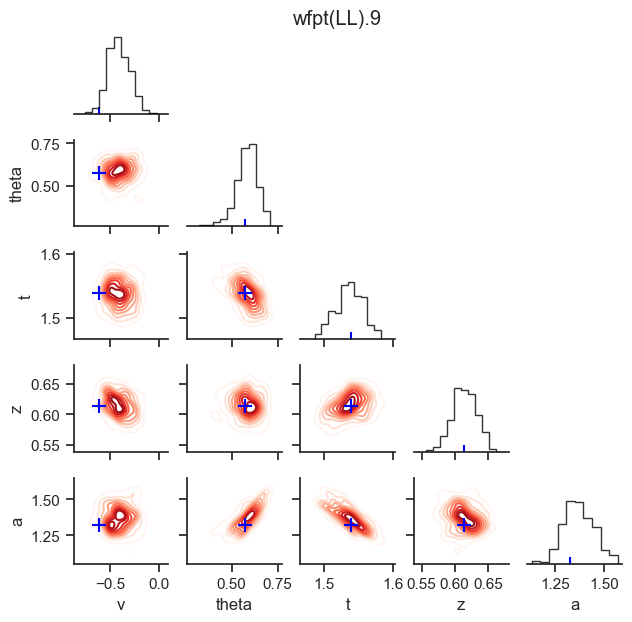

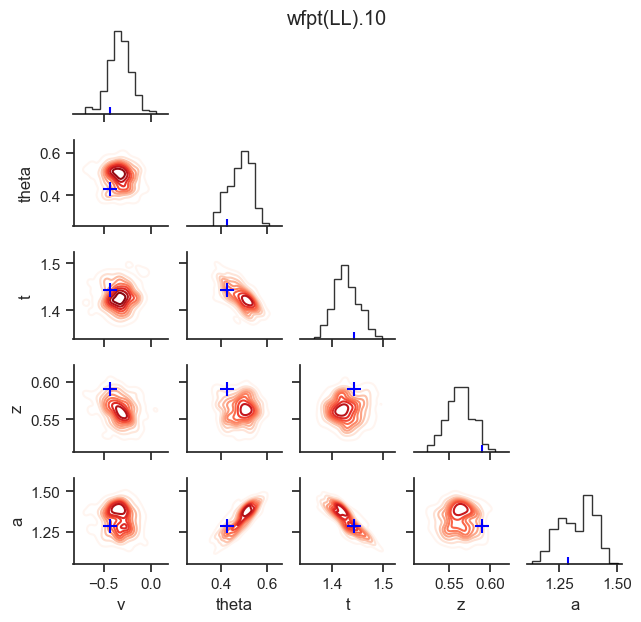

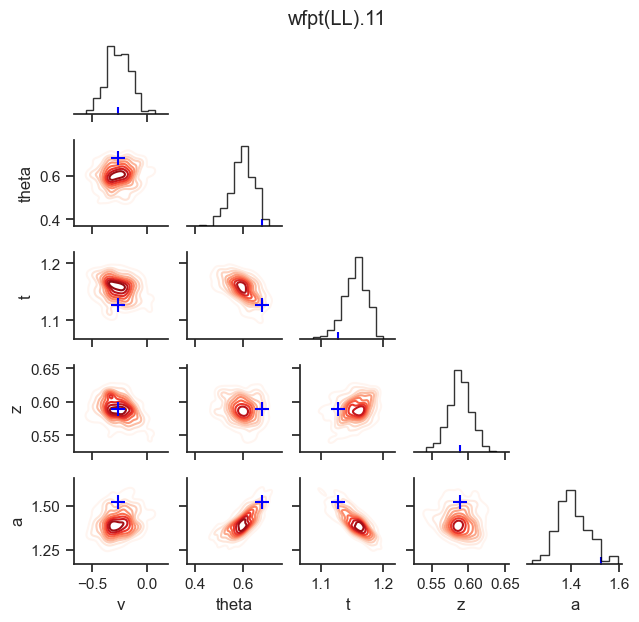

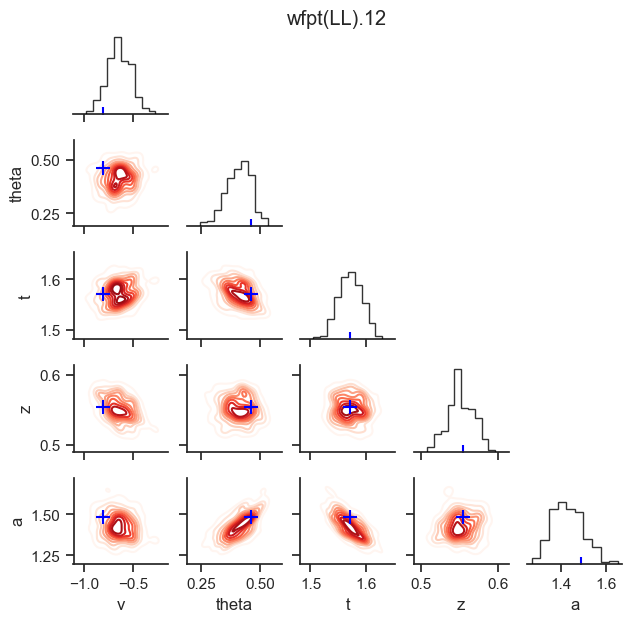

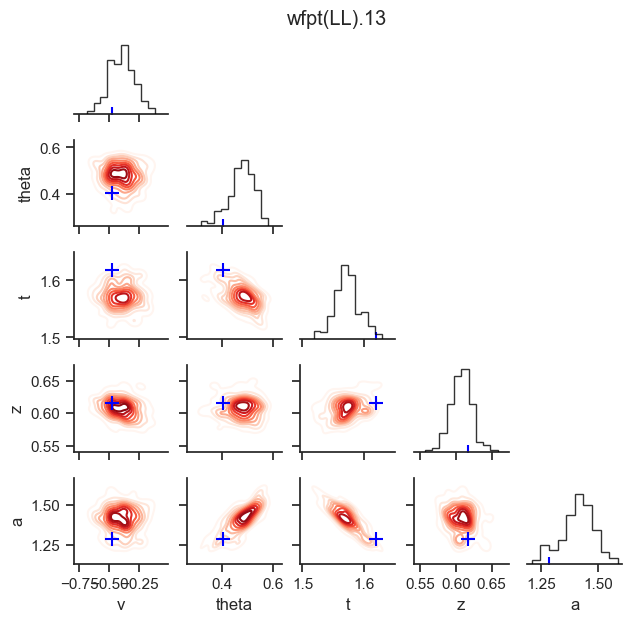

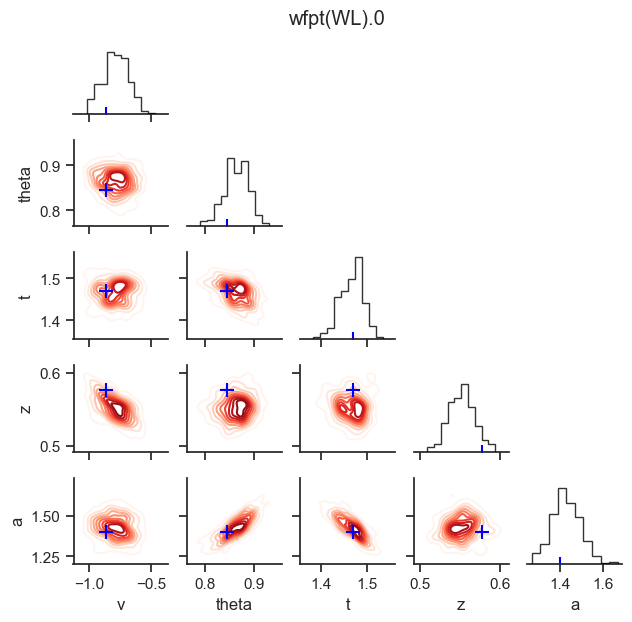

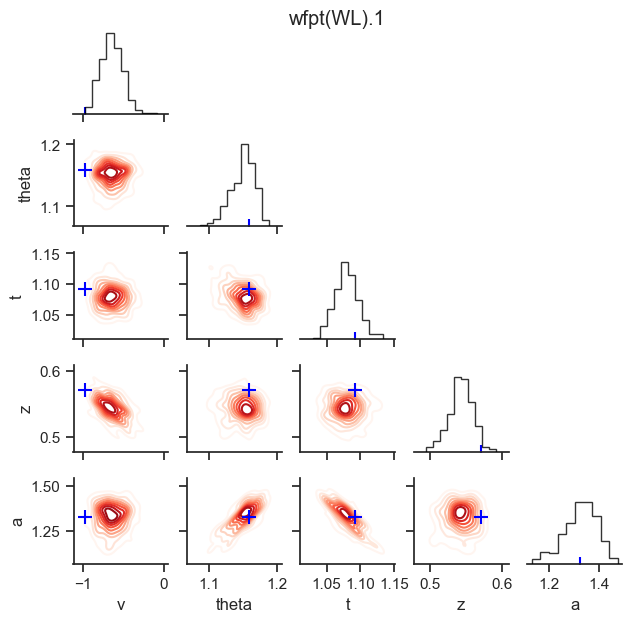

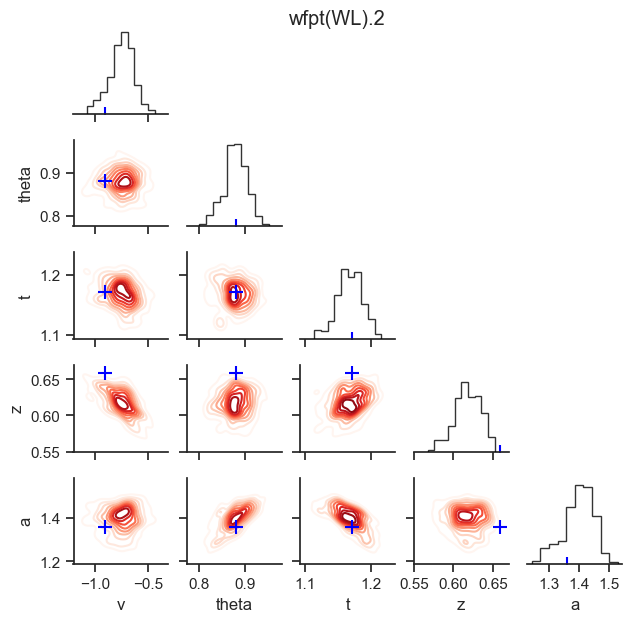

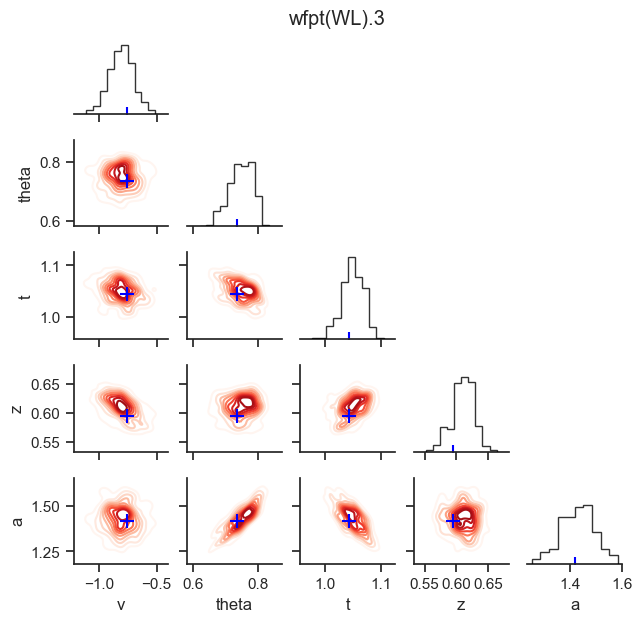

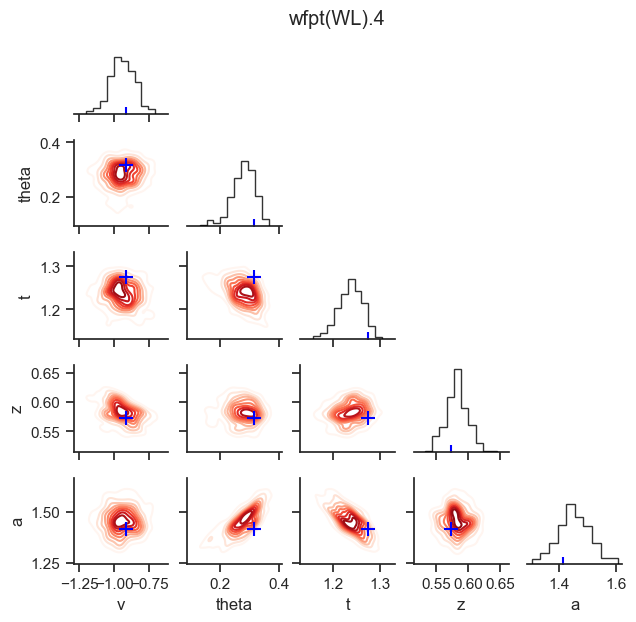

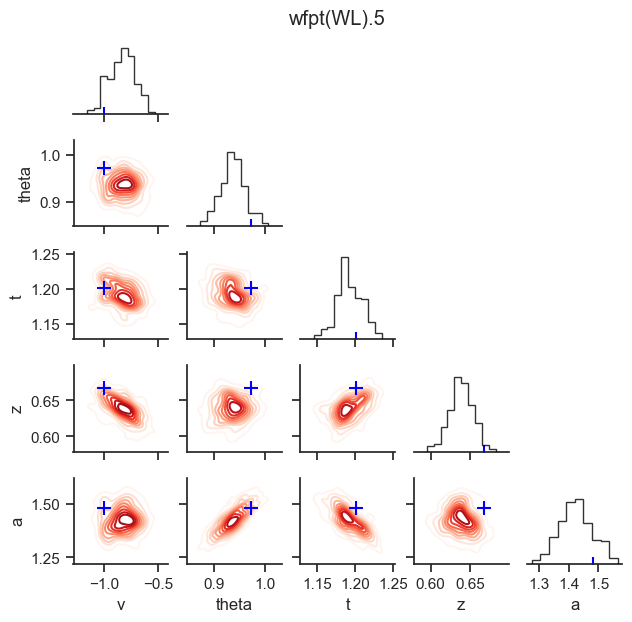

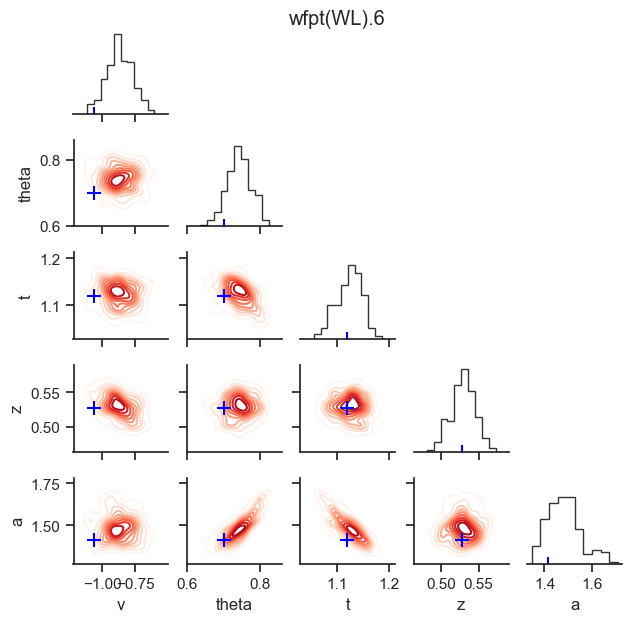

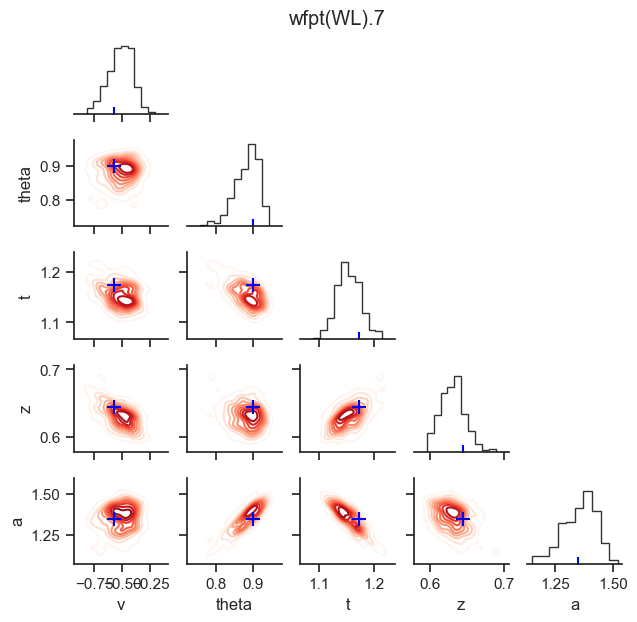

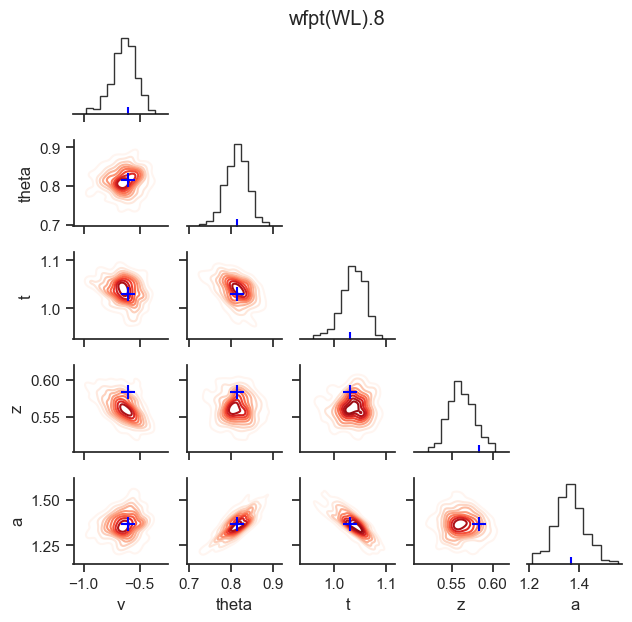

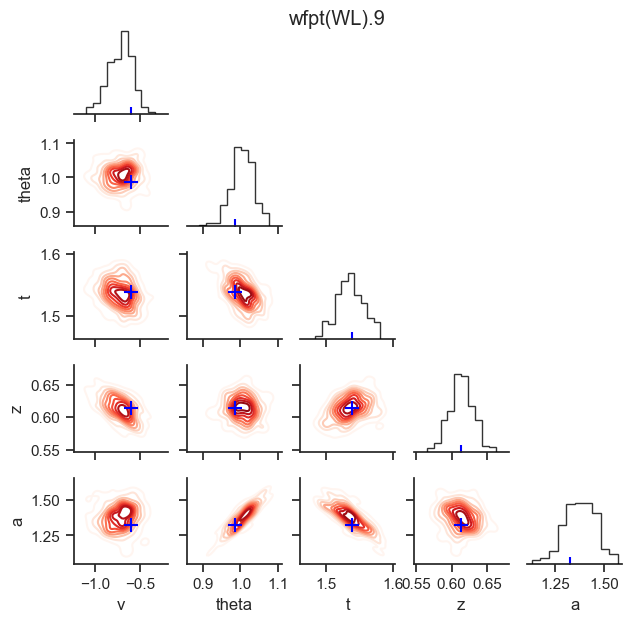

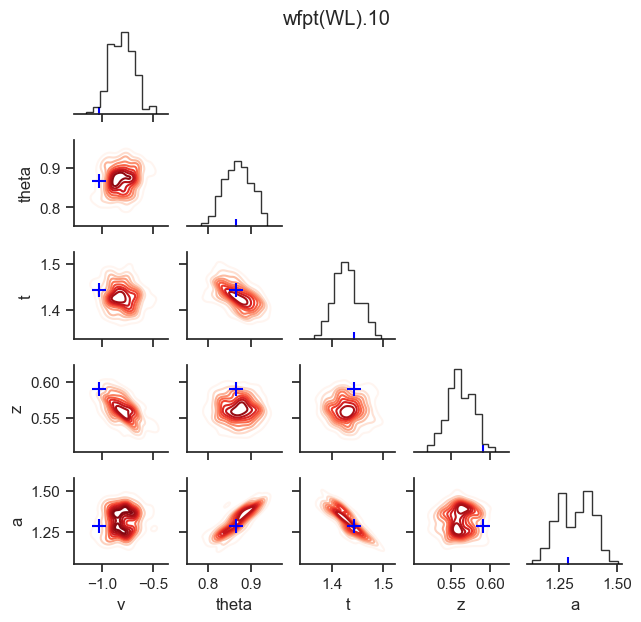

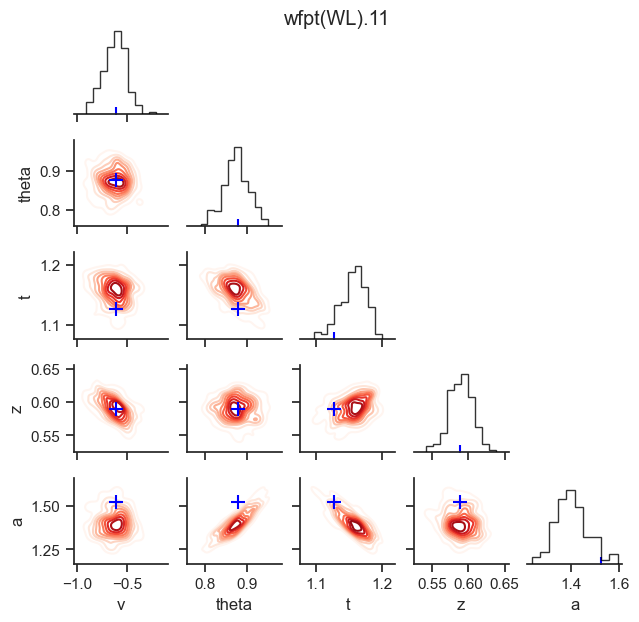

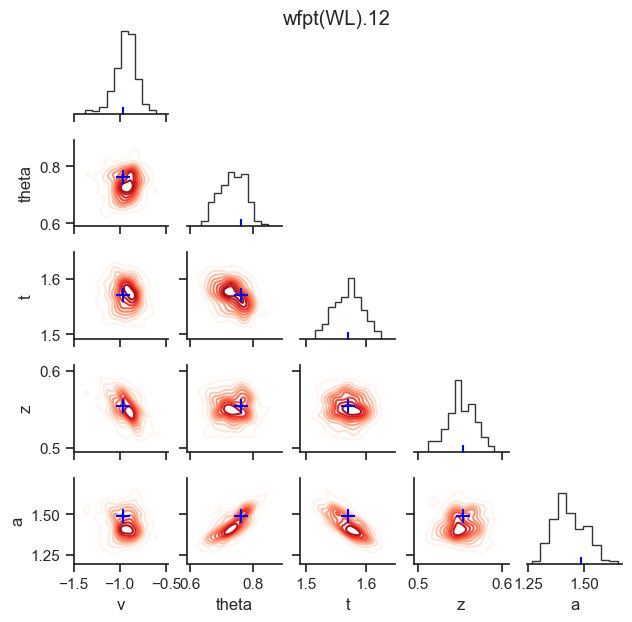

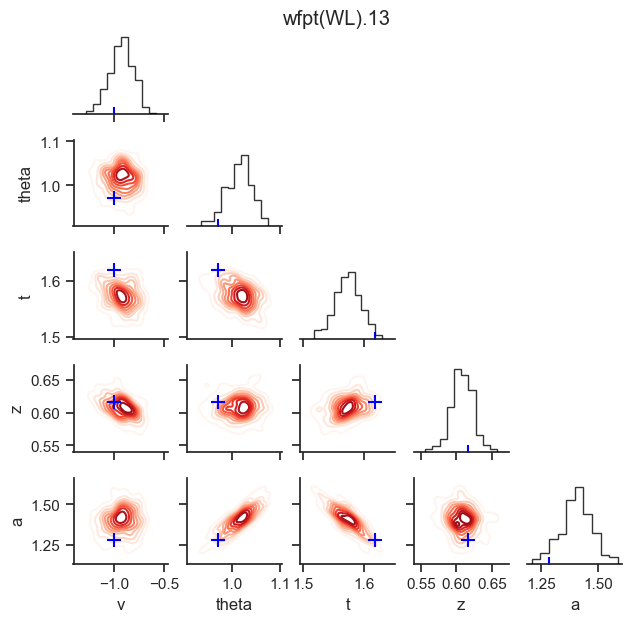

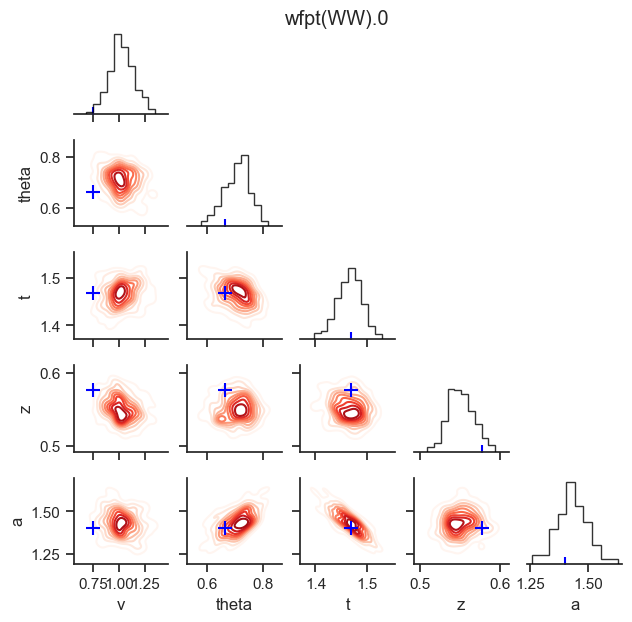

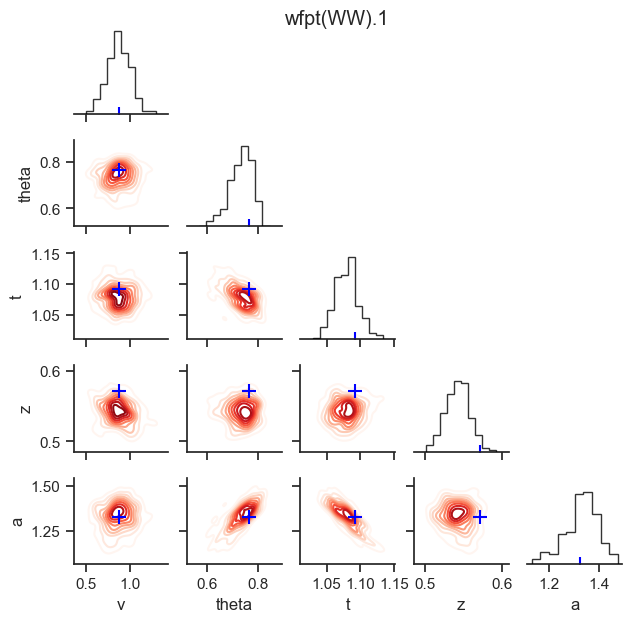

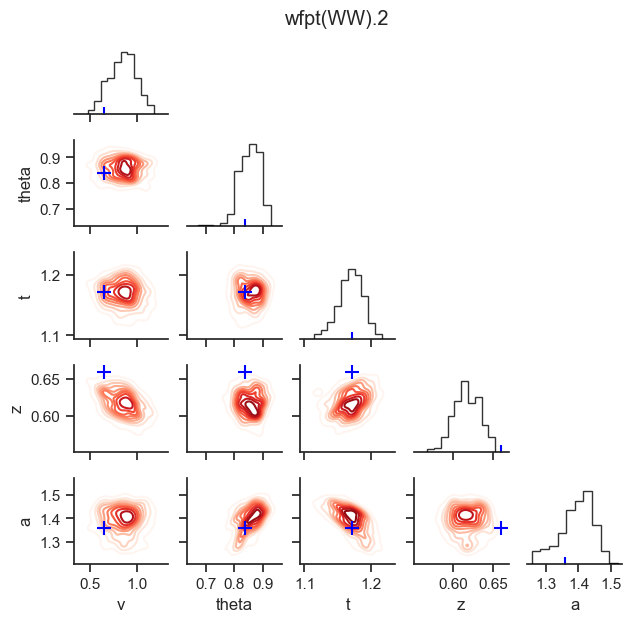

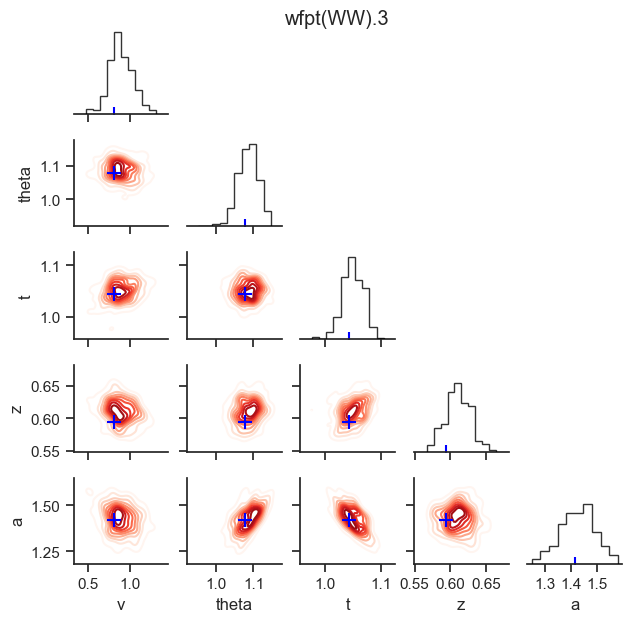

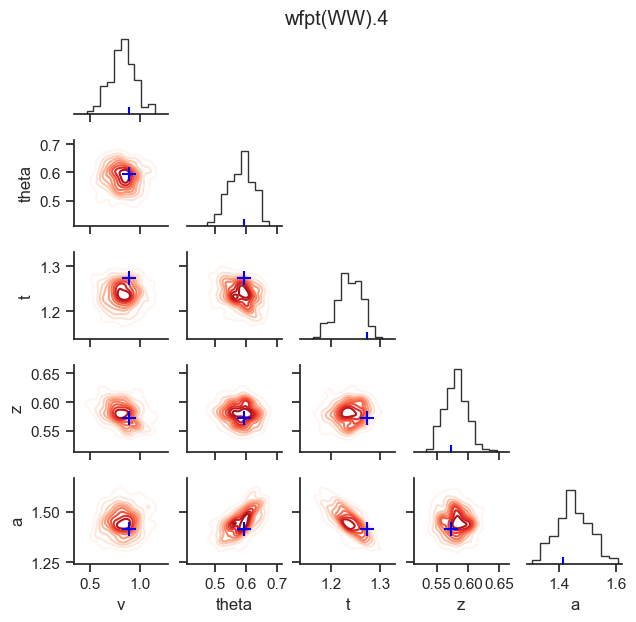

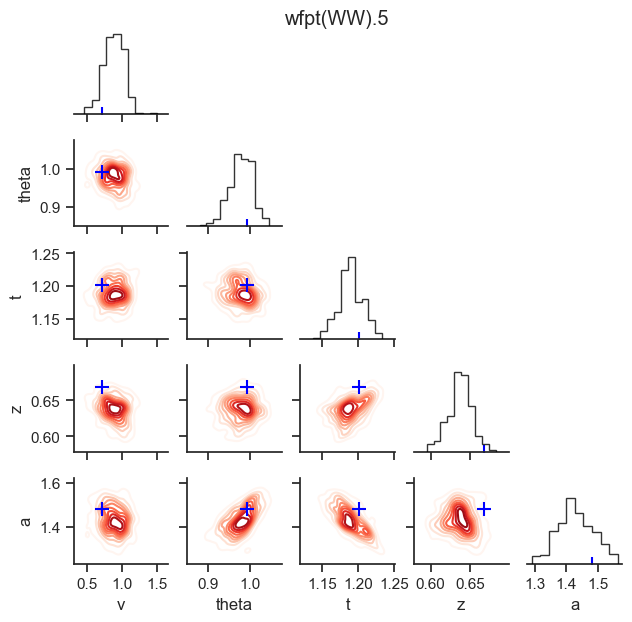

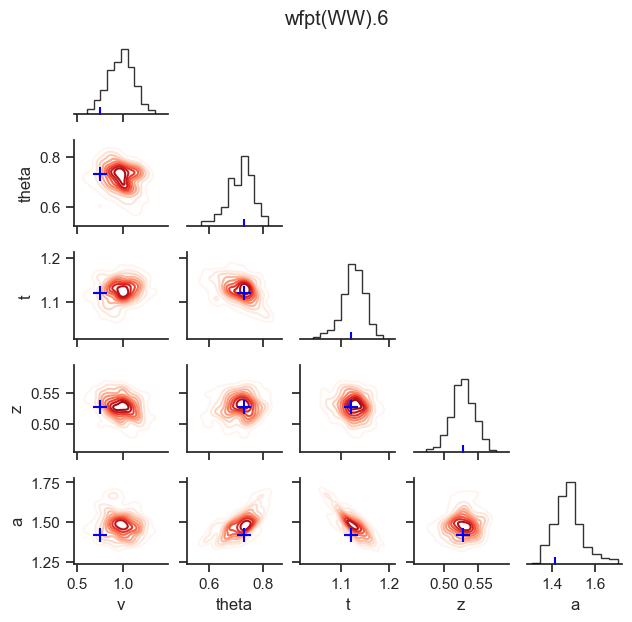

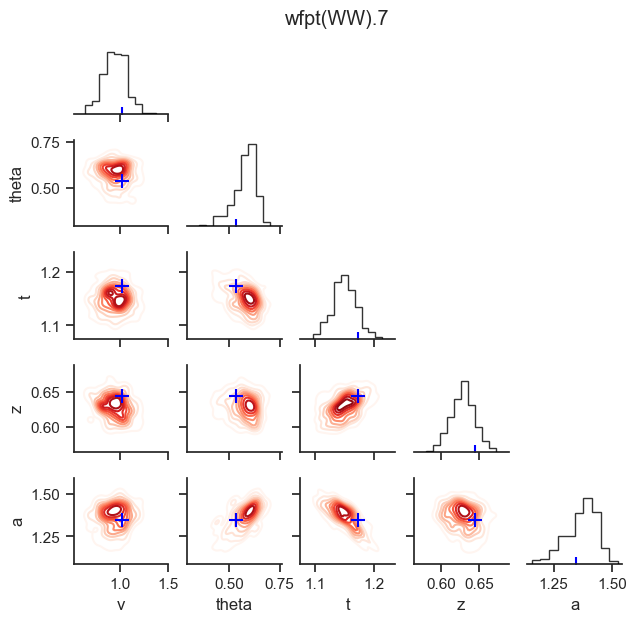

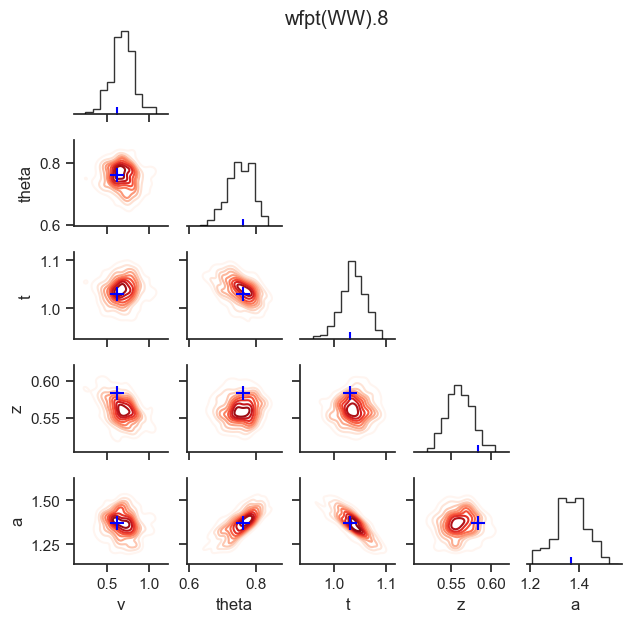

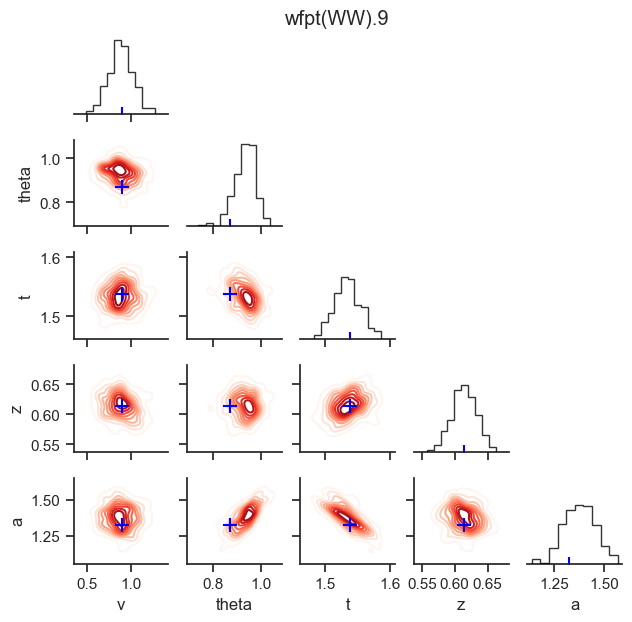

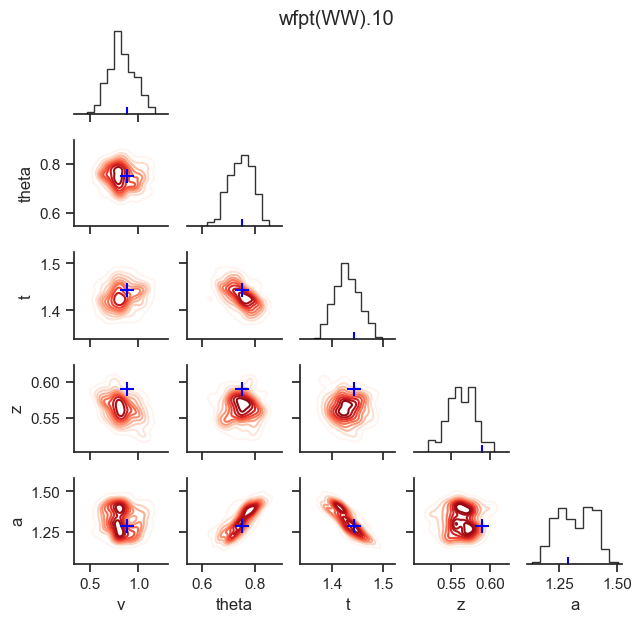

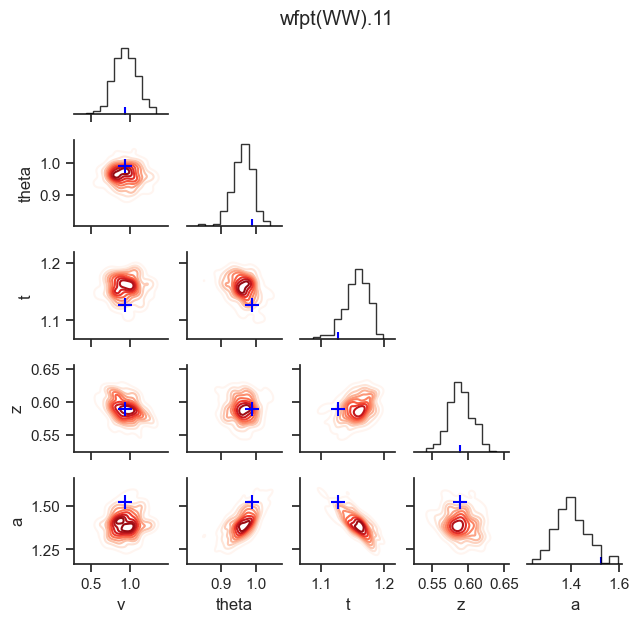

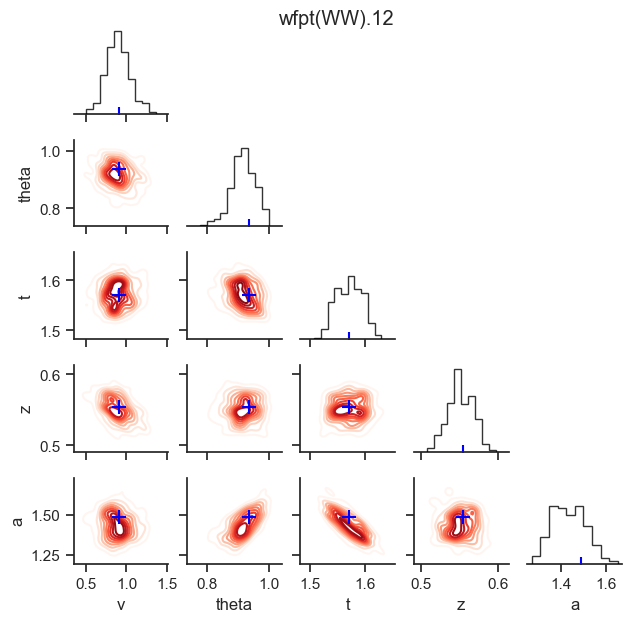

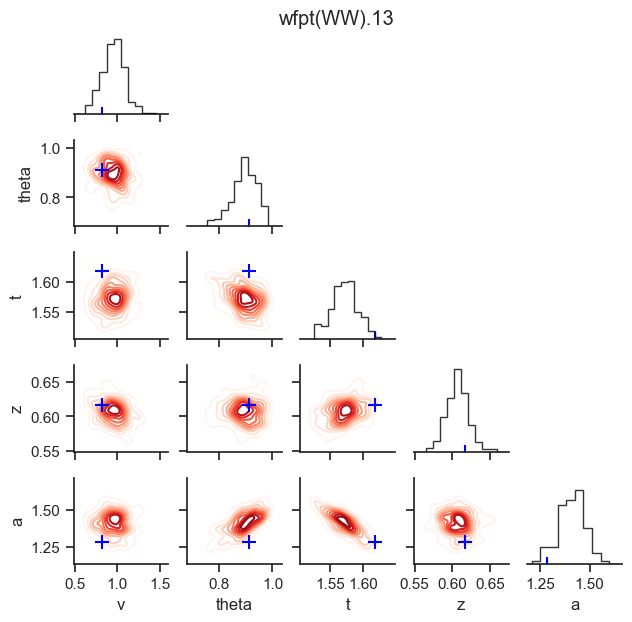

In [49]:
from hddm.plotting import plot_posterior_pair
plot_posterior_pair(hddmnn_model_sim, save = False, 
                    parameter_recovery_mode = True,
                    samples = 500,
                    figsize = (6, 6))

#### Adding to the bank of SSMs: User Supplied Custom Models

In [37]:
from hddm.model_config import model_config
my_model_config =  {
                    "params": ["v", "a", "z", "t", "theta"], 
                    "params_trans": [0, 0, 1, 0, 0], 
                    "params_std_upper": [1.5, 1.0, None, 1.0, 1.0],
                    "param_bounds": [[-3.0, 0.3, 0.1, 1e-3, 0.0], 
                                     [3.0, 2.5, 0.9, 2.0, 1.1]], 
                    "boundary": hddm.simulators.bf.constant, 
                    "n_params": 4, 
                    "params_default": [0.0, 1.0, 0.5, 1e-3], 
                    "hddm_include": ["z"], 
                    "n_choices": 2,
                    "choices": [-1, 1],
                    "slice_widths": {"v": 1.5, "v_std": 1,  
                                     "a": 1, "a_std": 1, 
                                     "z": 0.1, "z_trans": 0.2, 
                                     "t": 0.01, "t_std": 0.15},
                    }

In [ ]:
from hddm.torch.mlp_inference_class import load_torch_mlp

custom_network = load_torch_mlp(model = 'angle')

In [ ]:
hddm_model_custom = hddm.HDDMnn(data = data,
                                include = ["z",  "theta"], 
                                model = 'custom',
                                model_config = my_model_config,
                                network = custom_network)
                                
hddm_model_custom.sample(1000, burn = 500)

#### Connecting SSMs with Reinforcement Learning

In [2]:
hddm.model_config_rl.model_config_rl["RWupdate"] =  {"doc": "Rescorla-Wagner update rule.",
                                                     "params": ["rl_alpha"],
                                                     "params_trans": [0],
                                                     "params_std_upper": [10],
                                                     "param_bounds": [[0.0], [1.0]],
                                                     "params_default": [0.5]}

In [3]:
data = hddm.load_csv(hddm.__path__[0] + '/examples/demo_HDDMnnRL/rlssm_data.csv')

In [4]:
data

response        rt  feedback  subj_idx  split_by  trial  q_init
0           0.0  2.729579       0.0         0         0      1     0.5
1           1.0  3.090593       1.0         0         0      2     0.5
2           1.0  3.892617       1.0         0         0      3     0.5
3           1.0  2.429583       1.0         0         0      4     0.5
4           1.0  2.566581       1.0         0         0      5     0.5
...         ...       ...       ...       ...       ...    ...     ...
29995       1.0  3.381547       1.0        19         2    496     0.5
29996       1.0  3.324544       0.0        19         2    497     0.5
29997       1.0  3.132535       0.0        19         2    498     0.5
29998       0.0  3.206539       0.0        19         2    499     0.5
29999       1.0  5.009474       0.0        19         2    500     0.5

[30000 rows x 7 columns]

In [5]:
rlssm_model = hddm.HDDMnnRL(data,
    model="weibull",
    rl_rule="RWupdate",
    non_centered=True,
    include=["z", "alpha", "beta", "rl_alpha"],
    p_outlier=0.0)
    
rlssm_model.sample(2000, burn=1000)


Printing model specifications -- 
ssm:  weibull
rl rule:  RWupdate
using non-centered dist.:  True
Using default priors: Uninformative
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10
Using non-centered distributions.
 [-----------------100%-----------------] 2001 of 2000 complete in 6648.9 sec

Plotting v
Plotting v_std
Plotting a
Plotting a_std
Plotting z
Plotting z_std
Plotting t
Plotting t_std
Plotting alpha
Plotting alpha_std
Plotting beta
Plotting beta_std
Plotting rl_alpha
Plotting rl_alpha_std


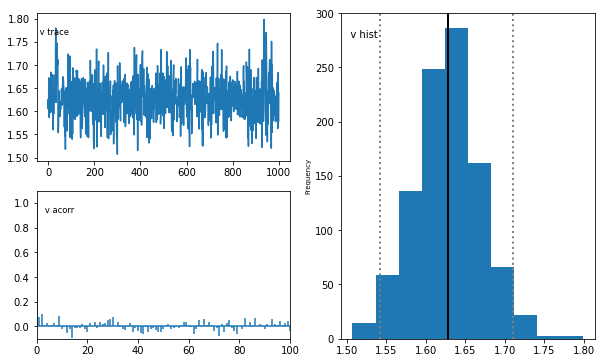

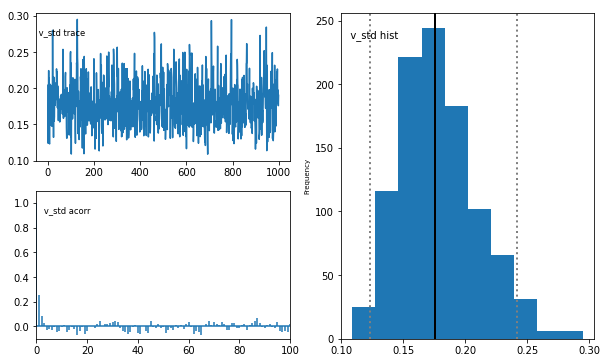

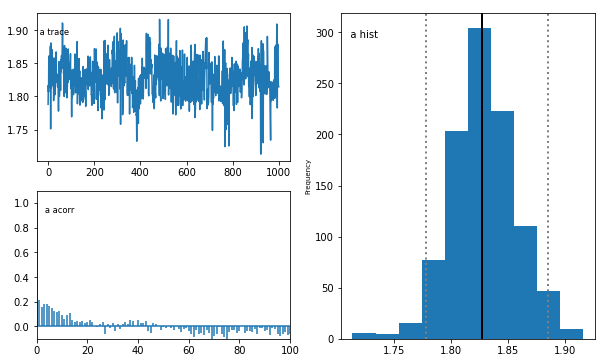

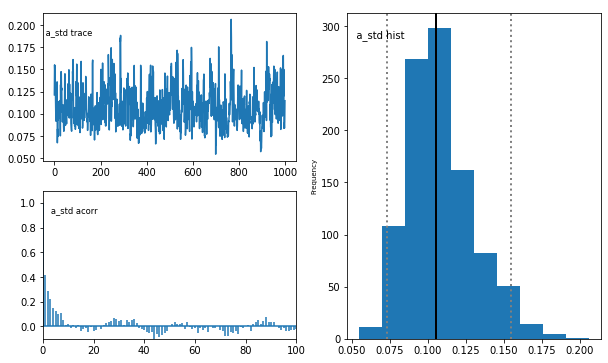

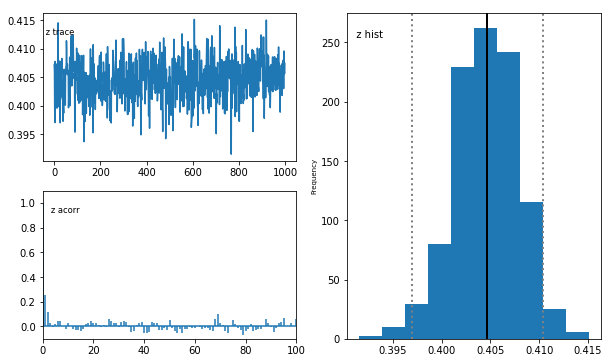

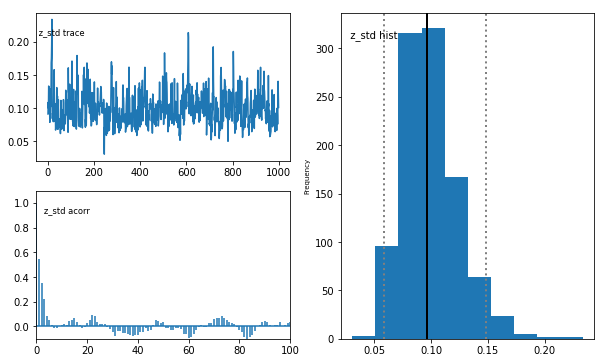

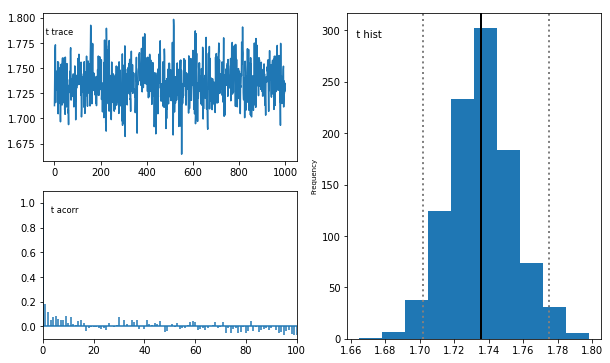

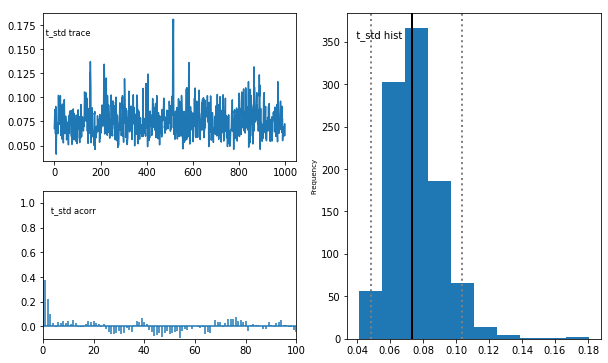

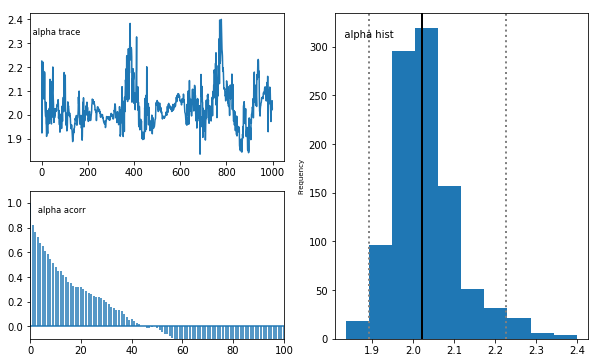

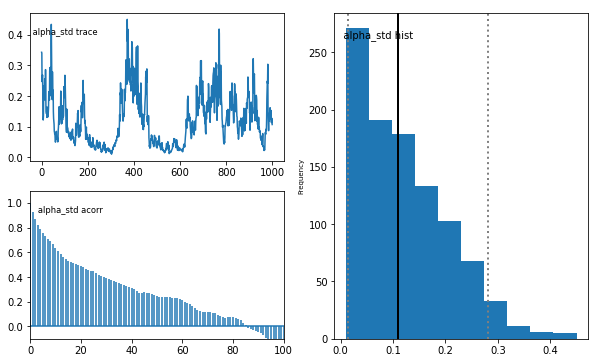

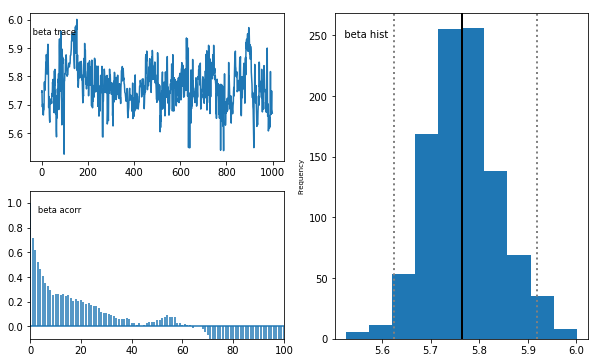

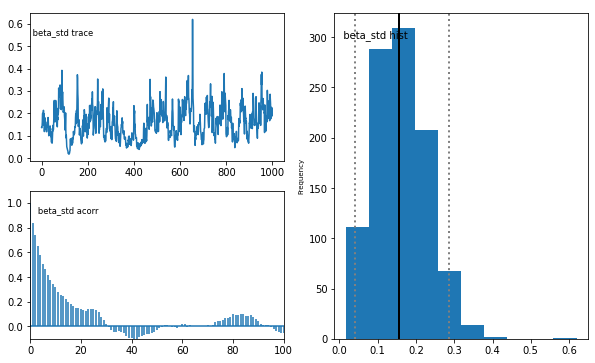

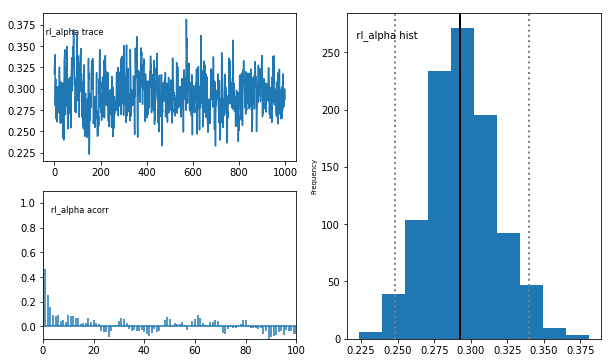

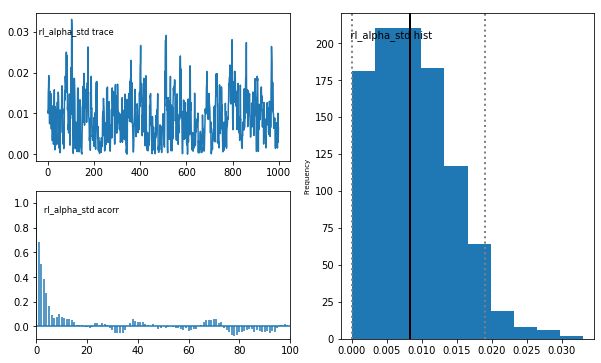

In [8]:
rlssm_model.plot_posteriors()

##### `HDDMnnRLRegressor`: Linking trial-by-trail neural covariates to model parameters

In [2]:
reg_data = hddm.load_csv(hddm.__path__[0] + '/examples/demo_HDDMnnRL/rlssm_reg_data.csv')

In [3]:
reg_data

response        rt  feedback  subj_idx  split_by  trial  neural_reg  \
0          1.0  1.923514       1.0         0         0      1    0.880625   
1          1.0  1.881514       1.0         0         0      2   -0.422714   
2          1.0  2.209510       1.0         0         0      3    1.136356   
3          0.0  1.587516       0.0         0         0      4   -1.509013   
4          1.0  1.639516       1.0         0         0      5   -2.070240   
...        ...       ...       ...       ...       ...    ...         ...   
9995       0.0  1.825360       0.0        19         0    496   -0.223202   
9996       1.0  1.716362       1.0        19         0    497   -0.273854   
9997       1.0  1.459362       1.0        19         0    498   -2.283859   
9998       0.0  1.596362       0.0        19         0    499   -0.700504   
9999       1.0  1.757361       0.0        19         0    500    0.142879   

      q_init  
0        0.5  
1        0.5  
2        0.5  
3        0.5  
4        0.5  
...      ...  
9995     0.5  
9996     0.5  
9997     0.5  
9998     0.5  
9999     0.5  

[10000 rows x 8 columns]

In [4]:
rlssm_reg_model = hddm.HDDMnnRLRegressor(reg_data,
    'a ~ 1 + neural_reg',
    model="weibull",
    rl_rule="RWupdate",
    include=["z", "alpha", "beta", "rl_alpha"],
    p_outlier=0.0)

rlssm_reg_model.sample(2000, burn=1000)

Using default priors: Uninformative

Printing model specifications -- 
ssm:  weibull
rl rule:  RWupdate
using non-centered dist.:  False
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


<string>:14: UserWarning: Boundary violation of regressor part.


 [-----------------100%-----------------] 2001 of 2000 complete in 3455.8 sec

Plotting v
Plotting v_std
Plotting z
Plotting z_std
Plotting t
Plotting t_std
Plotting alpha
Plotting alpha_std
Plotting beta
Plotting beta_std
Plotting rl_alpha
Plotting rl_alpha_std
Plotting a_Intercept
Plotting a_Intercept_std
Plotting a_neural_reg


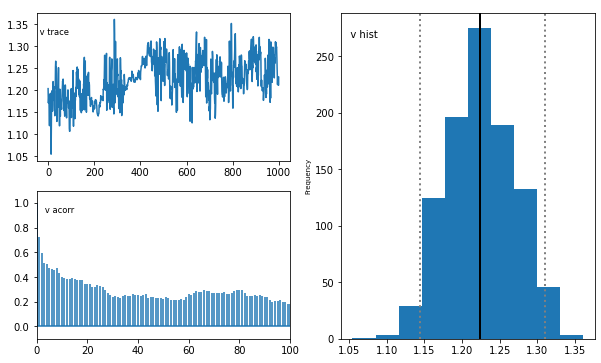

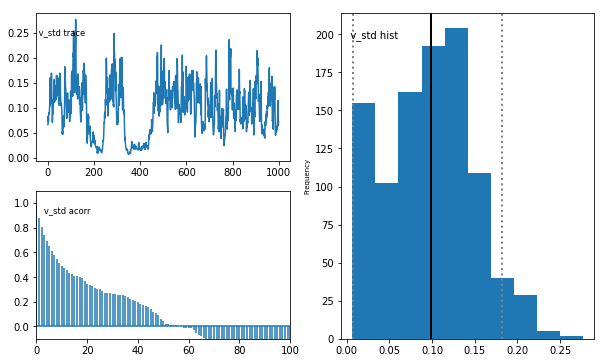

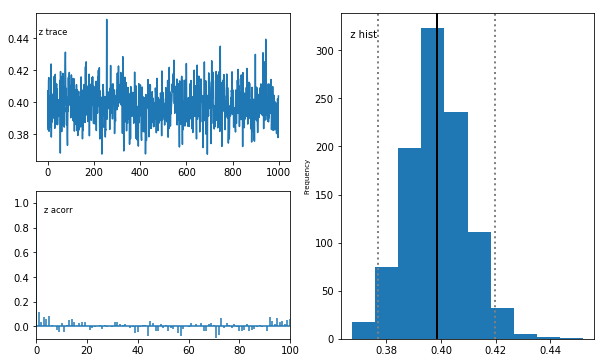

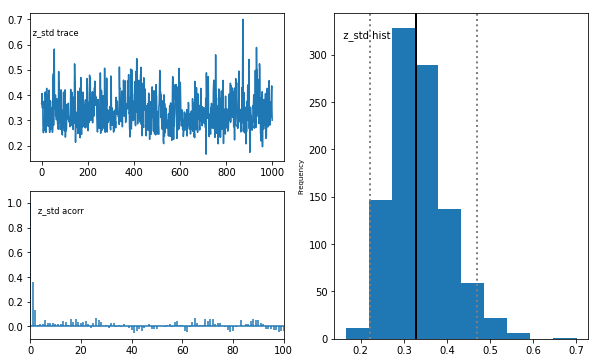

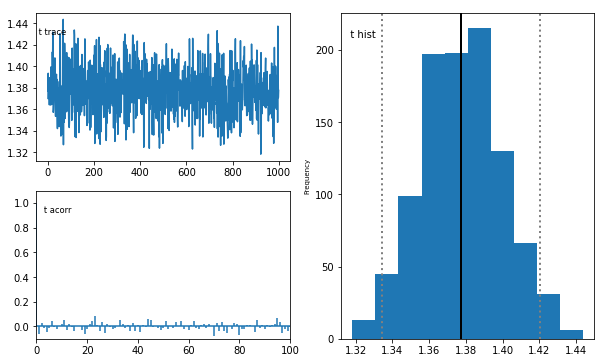

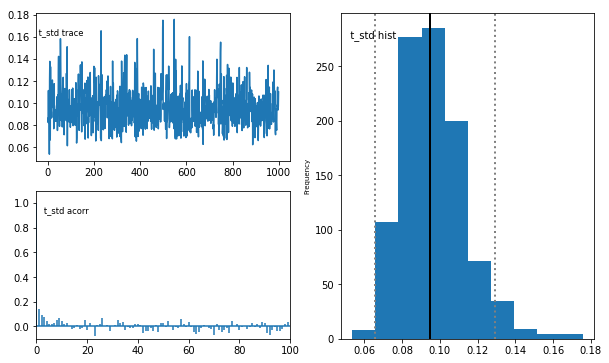

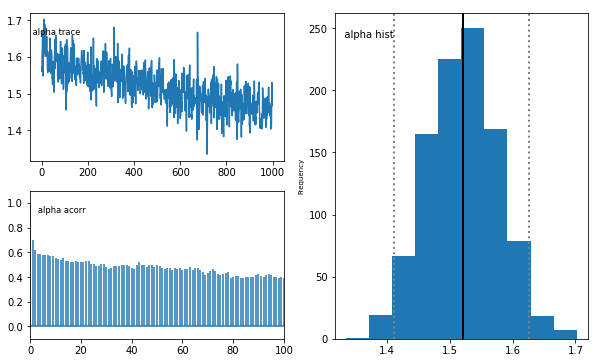

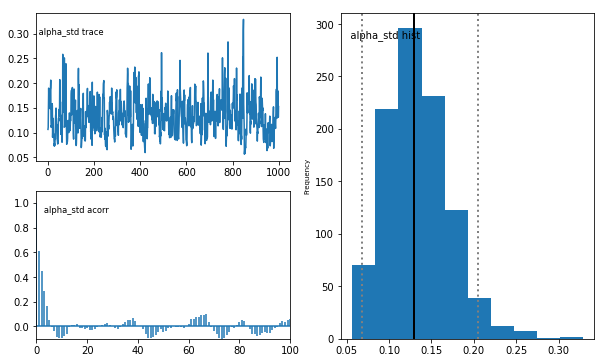

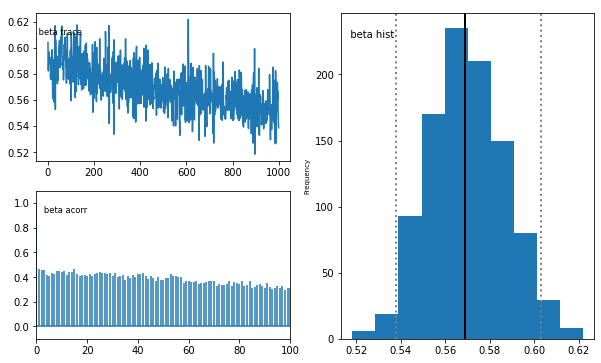

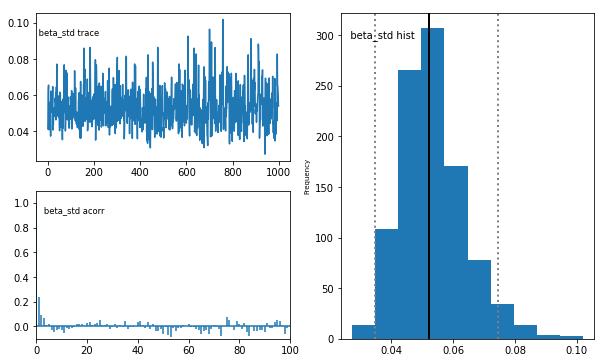

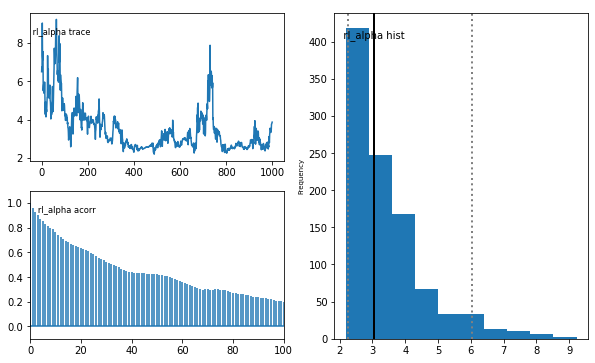

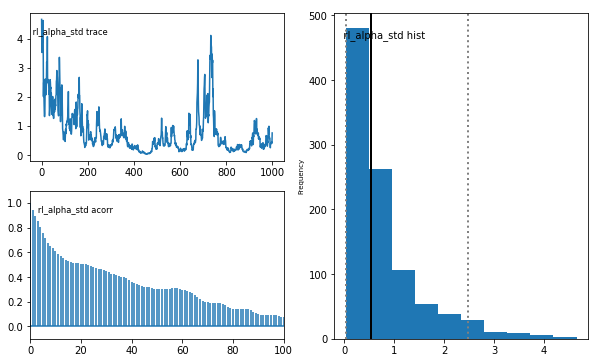

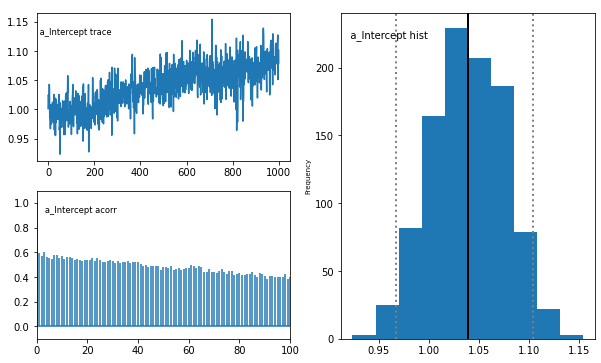

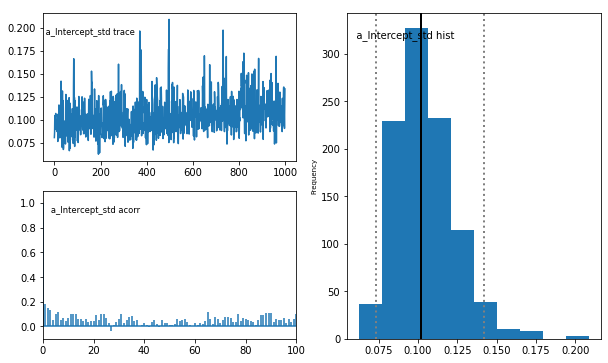

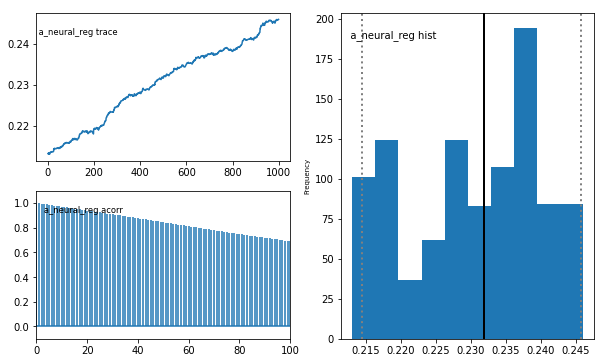

In [5]:
rlssm_reg_model.plot_posteriors()